In [4]:
import os
import glob
import shutil
import math

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns


In [5]:
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import label_figure

In [6]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def label_figure(fig, data_identifier):                                                                                                                                     
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)    

In [7]:
%matplotlib notebook

# Set source dirs

In [8]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

In [9]:
outdir = os.path.join(aggregate_dir, 'luminance-analysis')
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [10]:
if not os.path.exists(os.path.join(outdir, 'roi-luminance-arrays')):
    os.makedirs(os.path.join(outdir, 'roi-luminance-arrays'))

# Get aggregate data

In [11]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)


/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

# Select datasets with RFs + blobs

In [12]:
include_sessions = []
included_ixs = []
for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
    if any(['rf' in v for v in g['experiment'].values]) and 'blobs' in g['experiment'].values:
        include_sessions.append((animalid, session, fov))
        included_ixs.extend(g.index.tolist())
        
dsets = sdata.loc[included_ixs]
fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
dsets['fovnum'] = fovnums

print(dsets.shape)

(137, 6)


# Get counts per area

In [13]:
dsets[dsets['experiment']=='blobs'].groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,13,13,13,13,13
Lm,12,12,12,12,12
V1,11,11,11,11,11


In [14]:
dsets[dsets['experiment'].isin(['rfs', 'rfs10'])].groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,14,14,14,14,14
Lm,12,12,12,12,12
V1,15,15,15,15,15


In [15]:
dsets.head()

,animalid,experiment,fov,session,visual_area,fovnum
115,JC076,blobs,FOV1_zoom2p0x,20190420,V1,1
116,JC076,retino,FOV1_zoom2p0x,20190420,V1,1
117,JC076,rfs,FOV1_zoom2p0x,20190420,V1,1
118,JC076,blobs,FOV1_zoom2p0x,20190501,V1,1
119,JC076,retino,FOV1_zoom2p0x,20190501,V1,1


In [16]:
# incl_sessions = ['20190522', '20191006', '20190616',
#                  '20190609', '20190614', '20191018']

# dsets = dsets[dsets['session'].isin(incl_sessions)]


In [17]:
#dsets.groupby(['visual_area']).count()


# Load data

In [18]:
def get_trial_stats(animalid, session, fovnum, curr_exp='blobs',
                                   traceid='traces001', response_type='dff',
                                   responsive_test='ROC', responsive_thr=0.05, n_stds=0.):
    
    # Load experiment neural data
    fov = 'FOV%i_zoom2p0x' % fovnum
    if curr_exp == 'blobs':
        exp = util.Objects(animalid, session, fov, traceid=traceid)
    elif curr_exp == 'gratings':
        exp = util.Gratings(animalid, session, fov, traceid=traceid)
    else:
        print("DUNNO WHAT TO LOAD.")
        
    exp.load(trace_type='dff', update_self=True, make_equal=True)
    labels = exp.data.labels.copy()

    # Get stimulus config info
    sdf = exp.data.sdf
    sdf = reformat_morph_values(sdf)
    n_conditions = len(sdf['size'].unique())
    color_list = sns.color_palette('cubehelix', n_conditions)
    cond_colors = dict((k, color_list[i]) for i, k in enumerate(sorted(sdf['size'].unique()))) #.keys()))

    # ----- PUPIL/FACE STUFF -------------------------------
    # Add stimulus config info to face data
    trial_key = pd.DataFrame({'config': [g['config'].unique()[0] \
                             for trial, g in labels.groupby(['trial'])],
                  'trial': [int(trial[5:]) \
                             for trial, g in labels.groupby(['trial'])]})

    # ----- NEURAL STUFF -------------------------------
    # Get nrois x ntrials array
    roi_responses = pd.DataFrame(np.vstack([exp.data.traces.iloc[g.index].mean(axis=0)\
                                        for trial, g in labels.groupby(['trial'])]),
                                index=[int(trial[5:]) for trial, g in labels.groupby(['trial'])])

    # Get responsive cells
    responsive_cells, ncells_total = exp.get_responsive_cells(response_type=response_type,\
                                                              responsive_test=responsive_test, 
                                                              responsive_thr=responsive_thr,
                                                              n_stds=n_stds)
    print("%i out of %i cells pass responsive test." % (len(responsive_cells), ncells_total))
    neuraldata = roi_responses[responsive_cells]

    return neuraldata, trial_key, sdf
    

In [19]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


# Stim reformatiting functions

In [20]:
import cv2
def resize_image_to_coords(im, size_deg=30, pix_per_deg=10.01, aspect_scale=1.747):
    print(pix_per_deg)
    ref_dim = max(im.shape)
    resize_factor = ((size_deg*pix_per_deg) / ref_dim ) / pix_per_deg
    scale_factor = resize_factor * aspect_scale
    
    imr = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)
    
    return imr

In [21]:
def resize_image_to_screen(im, size_deg=30, pix_per_deg=16.06, aspect_scale=1.747):
    ref_dim = max(im.shape)
    #resize_factor = ((size_deg*pix_per_deg) / ref_dim ) / pix_per_deg
    #print(resize_factor)
    #scale_factor = resize_factor * aspect_scale
    scale_factor = (size_deg*aspect_scale)/(1./pix_per_degW) / ref_dim
    imr = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)

    return imr

In [22]:
def convert_range(oldval, newmin=None, newmax=None, oldmin=None, oldmax=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

# RF calculation functions

In [42]:
def update_rfparams(rfparams):

    screen_pix_x, screen_pix_y = rfparams['screen_resolution']
    screen_xmin_deg, screen_xmax_deg = rfparams['screen_xlim_deg']
    screen_ymin_deg, screen_ymax_deg = rfparams['screen_ylim_deg']
    stim_xpos, stim_ypos = rfparams['stim_pos']
    
    # Convert specified stim position to pixel space
    stim_xpos_pix = convert_range(stim_xpos, newmin=0, newmax=screen_pix_x, 
                                  oldmin=screen_xmin_deg, oldmax=screen_xmax_deg)
    stim_ypos_pix = convert_range(stim_ypos, newmin=0, newmax=screen_pix_y, 
                                  oldmin=screen_ymin_deg, oldmax=screen_ymax_deg)

    # Create "screen" array to project image onto
    stim_xpos_pix = int(round(stim_xpos_pix))
    stim_ypos_pix = int(round(stim_ypos_pix))
    #print(stim_xpos_pix, stim_ypos_pix)

    row_vals_pix = [convert_range(rv, newmin=0, newmax=screen_pix_y, 
                    oldmin=screen_ymin_deg, oldmax=screen_ymax_deg) for rv in rfparams['row_vals']]

    col_vals_pix = [convert_range(cv, newmin=0, newmax=screen_pix_x, 
                    oldmin=screen_xmin_deg, oldmax=screen_xmax_deg) for cv in rfparams['col_vals']]

    converted = {'stim_pos_pix': (stim_xpos_pix, stim_ypos_pix),
                 'row_vals_pix': row_vals_pix, 
                 'col_vals_pix': col_vals_pix}
    
    rfparams.update(converted)
    
    return rfparams


def transform_rfmap(rfmap, rfparams, pix_per_deg=16.05):

    # Normalize rf map to range bw (0, 1)
    normed_rfmap = rfmap/rfmap.max()

    # Resize RF map to match image array
    rfsize = int(np.ceil(pix_per_deg * rfparams['spacing']))
    #print("rf tile size:", rfsize)

    # Create RF map array
    screen_x, screen_y = rfparams['screen_resolution']
    rfscreen = np.ones((screen_y, screen_x))
    for rii, ri in enumerate(rfparams['row_vals_pix']):
        for cii, ci in enumerate(rfparams['col_vals_pix']):
            r_ix = int(round(ri-(rfsize/2.)))
            c_ix = int(round(ci-(rfsize/2.)))
            #print(r_ix, c_ix)
            rfscreen[r_ix:r_ix+rfsize, c_ix:c_ix+rfsize] = normed_rfmap[rii, cii]

    return rfscreen

In [24]:

def transform_stim_image(curr_img, rfparams, size_deg=30., pix_per_deg=16.05):
    
    screen_pix_x, screen_pix_y = rfparams['screen_resolution']
    stim_xpos_pix, stim_ypos_pix = rfparams['stim_pos_pix']
    
    # Resize image (specify pixels based on selected size in degrees)
    imr_pix = resize_image_to_screen(curr_img, size_deg=size_deg, pix_per_deg=pix_per_deg) #, aspect_scale=1.747)

    # Pad resized image to match rf screen
    x_pad2 = round(screen_pix_x - (stim_xpos_pix + imr_pix.shape[1]/2.)) # Get far right edge
    x_pad1 = round(stim_xpos_pix - (imr_pix.shape[1]/2.)) # Get left edge
    y_pad1 = round(screen_pix_y - (stim_ypos_pix + imr_pix.shape[0]/2.)) # Get top edge
    y_pad2 = round(stim_ypos_pix - (imr_pix.shape[0]/2.)) # Get bottom edge

    imscreen = np.pad(imr_pix, (( int(abs(y_pad1)), int(abs(y_pad2)) ), \
                                ( int(abs(x_pad1)), int(abs(x_pad2)) )), mode='constant', constant_values=0)
    #print(size_deg, imscreen.shape)

    # Check if image is blown up beyond array size
    if x_pad2 < 0:     # need to trim right edge:
        imscreen = imscreen[:, 0:screen_pix_x]
        print("...overblown on right edge", imscreen.shape)
    elif x_pad1 < 0:   # need to trim left edge
        trim_left = screen_pix_x - imscreen.shape[1]
        imscreen = imscreen[:, trim_left:]
        print("...overblown on left edge", imscreen.shape)

    if y_pad2 < 0:     # need to trim bottom edge:
        imscreen = imscreen[0:screen_pix_y, :]
        print("...overblown on bottom edge", imscreen.shape)
    elif y_pad1 < 0:   # need to trim top edge
        trim_top = screen_pix_y - imscreen.shape[0]
        imscreen = imscreen[trim_top:, :]
        print("...overblown on top edge", imscreen.shape)

    # Check if need extra padding:
    if imscreen.shape[0] < screen_pix_y:
        n_pad_extra = screen_pix_y - imscreen.shape[0]
        imscreen = np.pad(im_screen, ((0, n_pad_extra), (0, 0)), mode='constant', constant_value=0)
        print("...padding %i to bottom" % n_pad_extra, imscreen.shape)
    elif imscreen.shape[0] > screen_pix_y:
        imscreen = imscreen[0:screen_pix_y, :]
        print("...trimming %i off bottom" % (imscreen.shape[0]-screen_pix_y), imscreen.shape)

    if imscreen.shape[1] < screen_pix_x:
        n_pad_extra = screen_pix_x - imscreen.shape[1]
        imscreen = np.pad(im_screen, ((0, 0), (0, n_pad_extra)), mode='constant', constant_value=0)
        print("...padding %i to right" % n_pad_extra, imscreen.shape)
    elif imscreen.shape[1] > screen_pix_x:
        imscreen = imscreen[:, 0:screen_pix_x]
        print("...trimming %i off right" % (imscreen.shape[1]-screen_pix_x), imscreen.shape)

    return imscreen


In [25]:
def get_rfparams(screen_info, rfstats):
    rfparams = {'screen_xlim_deg': (screen_info['linminW'], screen_info['linmaxW']),
            'screen_ylim_deg': (screen_info['linminH'], screen_info['linmaxH']),
            'screen_resolution': tuple(screen_info['resolution']),
            'col_vals': rfstats['col_vals'],
            'row_vals': rfstats['row_vals'],
            'spacing': np.diff(rfstats['row_vals']).mean(),\
            'stim_pos': tuple(screen_info['stim_pos'])}
    rfparams = update_rfparams(rfparams)
    
    return rfparams

In [26]:
def plot_luminance_calculation(imarray, rfarray, lumarray, rfparams,
                               rf_cmap='hot', lum_cmap='jet'):
    
    fig, axes = pl.subplots(1, 3, figsize=(15,3))

    axes[0].imshow(imarray, origin='bottom', alpha=1, cmap='gray')
    axes[1].imshow(rfarray, origin='bottom', alpha=1, cmap=rf_cmap)
    axes[2].imshow(lumarray, origin='bottom', alpha=1, cmap=lum_cmap)

    for ax in axes:

        # Draw cells for RF tiling boundaries
        for rv in rfparams['col_vals_pix']:
            ax.axvline(rv - pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)
        ax.axvline(rv + pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)
        for rv in rfparams['row_vals_pix']:
            ax.axhline(rv - pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)
        ax.axhline(rv + pix_per_deg*rfparams['spacing']/2., color='w', lw=0.5)

        # Label coordinates
        ax.set_xticks(rfparams['col_vals_pix'])
        ax.set_xticklabels([int(i) for i in rfparams['col_vals']], fontsize=6)

        ax.set_yticks(rfparams['row_vals_pix'])
        ax.set_yticklabels([int(i) for i in rfparams['row_vals']], fontsize=6)
        
    return fig

#  Load stimulus images

In [27]:
# Get image paths:
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'
#sdf = DATA[datakey]['sdf']
#morph_levels = [m for m in sdf['morphlevel'].unique() if m != -1]
object_list = ['D1', 'M14', 'M27', 'M40', 'M53', 'M66', 'M79', 'M92', 'D2']
#object_list = ['D1', 'D2']

image_paths = []
for obj in object_list:
    stimulus_type = 'Blob_%s_Rot_y_fine' % obj
    image_paths.extend(glob.glob(os.path.join(stimulus_dir, stimulus_type, '*_y0.png')))
print("%i images found for %i objects" % (len(image_paths), len(object_list)))

images = {}
for object_name, impath in zip(object_list, image_paths):
    im = cv2.imread(impath)
    if object_name == 'D1':
        object_name = 'M0'
    if object_name == 'D2':
        object_name = 'M106'
    images[object_name] = im[:, :, 0]
print("im shape:", images['M0'].shape)
image_list = sorted(images.keys(), key=natural_keys)


9 images found for 9 objects
('im shape:', (618, 1080))


# Load object data

In [28]:
curr_exp = 'blobs'

responsive_test = 'ROC'
responsive_thr = 0.05
traceid = 'traces001'

exclude_sessions = ['JC078_20190426']

In [29]:
load_data = False
data_outfile = os.path.join(outdir, 'blobs_%s-%s-%.2f.pkl' % (response_type, responsive_test, responsive_thr))
if os.path.exists(data_outfile):
    with open(data_outfile, 'rb') as f:
        DATA = pkl.load(f)
else:
    load_data = True
    

In [30]:
if load_data:
    DATA = {}
    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        if '_'.join([animalid, session]) in exclude_sessions:
            continue
 
        #datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, curr_exp) 
        datakey ='%s_%s_fov%i' % (session, animalid, fovnum) 

        neuraldata, trial_key, sdf = get_trial_stats(animalid, session, fovnum, curr_exp,
                                                           traceid='traces001', response_type=response_type,
                                                           responsive_test='ROC', responsive_thr=0.05)

        DATA[datakey] = {'data': neuraldata,
                         'trial_key': trial_key,
                         'sdf': sdf}
    
    print("... saving extracted and formatted data...")
    print(data_outfile)
    with open(data_outfile, 'wb') as f:
        pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)


In [32]:
# # SAVE
# data_outfile = os.path.join(outdir, 'blobs_%s-%s-%.2f.pkl' % (response_type, responsive_test, responsive_thr))
# print(data_outfile)
# with open(data_outfile, 'wb') as f:
#     pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)
        

In [112]:
DATA.keys()

['20190512_JC083_fov1',
 '20190420_JC076_fov1',
 '20190603_JC080_fov1',
 '20190506_JC080_fov1',
 '20190510_JC083_fov1',
 '20190609_JC099_fov1',
 '20190614_JC091_fov1',
 '20190517_JC083_fov1',
 '20190613_JC097_fov1',
 '20191018_JC113_fov1',
 '20191111_JC120_fov1',
 '20190622_JC085_fov1',
 '20190501_JC076_fov1',
 '20191008_JC091_fov1',
 '20190504_JC078_fov1',
 '20190606_JC091_fov1',
 '20190605_JC090_fov1',
 '20191105_JC117_fov1',
 '20190602_JC091_fov1',
 '20190507_JC083_fov1',
 '20190616_JC097_fov1',
 '20190508_JC083_fov1',
 '20190612_JC099_fov1',
 '20190617_JC097_fov1',
 '20190511_JC083_fov1',
 '20190509_JC078_fov1',
 '20190430_JC078_fov1',
 '20191006_JC110_fov1',
 '20190525_JC084_fov1',
 '20190607_JC091_fov1',
 '20190522_JC084_fov1',
 '20190617_JC099_fov1',
 '20190627_JC091_fov1',
 '20190513_JC078_fov1',
 '20190502_JC076_fov1']

# Test with 1 dataset

In [156]:
session = '20190606'
animalid = 'JC091'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum
datakey ='%s_%s_fov%i' % (session, animalid, fovnum)  
print(datakey)


20190606_JC091_fov1


## Load session to get condition info

In [157]:
S = util.Session(animalid, session, fov, rootdir=rootdir)

# Get screen bounds: [bottom left upper right]
screen_bounds = [S.screen['linminH'], S.screen['linminW'], S.screen['linmaxH'], S.screen['linmaxW']]
screen_aspect = S.screen['resolution'][0] / S.screen['resolution'][1]

screen_width_deg = S.screen['linmaxW']*2
screen_height_deg = S.screen['linmaxH']*2

pix_per_degW = S.screen['resolution'][0] / screen_width_deg
pix_per_degH = S.screen['resolution'][1] / screen_height_deg 

print(pix_per_degW, pix_per_degH)
pix_per_deg = np.mean([pix_per_degW, pix_per_degH])
print("avg pix/deg: %.2f" % pix_per_deg)

stim_xpos, stim_ypos = S.get_stimulus_coordinates()

screen_info = S.screen.copy()
screen_info['stim_pos'] = (stim_xpos, stim_ypos)

[JC091] 20190606 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
(16.059366123436302, 16.042065861592622)
avg pix/deg: 16.05
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190606|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)


## Load RFs and get shared roi list

In [158]:
# Blob trial metrics
neuraldata = DATA['%s' % datakey]['data'].copy()
trial_key = DATA['%s' % datakey]['trial_key'].copy()
blobstats = pd.concat([neuraldata, trial_key], axis=1)
blobstats.index = blobstats['trial']
blobstats.drop('trial', axis=1, inplace=True)
sdf = DATA[datakey]['sdf']

# ROI list for objects
rois_objects = np.array(DATA['%s' % datakey]['data'].columns.tolist())
sizes = sorted(DATA['%s' % datakey]['sdf']['size'].unique())

# RF fit data
g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

# Get ROIs for both
print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
roi_list = np.intersect1d(rois_objects, rois_rfs)
print("%i rois common to both." % len(roi_list))

# Get RF/screen param info
rfparams = get_rfparams(screen_info, rfstats)

... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 110, RFs: 65
25 rois common to both.


## Calculate RF stimulus metrics

#### Resize image to specified degrees, map to screen coordinates
1. Get screen size in pixels and degrees (pix_per_deg)
2. Calculate resize factor for image in pixels, based on specified size + position (degrees), and known screen res
3. Resize image and pad to position it correctly in pixel space of screen
4. Get RF map in screen coords (pixels)
5. Plot overay

In [159]:
data_id = '%s|%s-%s_%s-%.2f' % (datakey, traceid, response_type, responsive_test, responsive_thr)
print(data_id)

20190606_JC091_fov1|traces001-dff_ROC-0.05


In [160]:
rf_cmap = 'hot'
lum_cmap = 'jet'
plot_roi = True

('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))


<IPython.core.display.Javascript object>


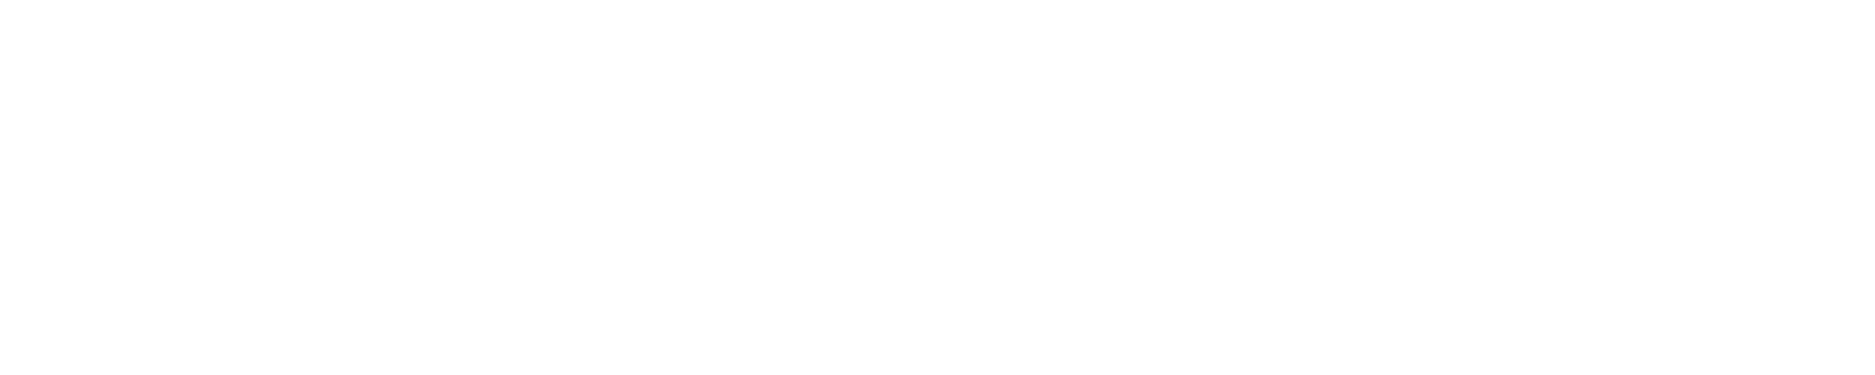

roi00017_sz30_M0


<IPython.core.display.Javascript object>


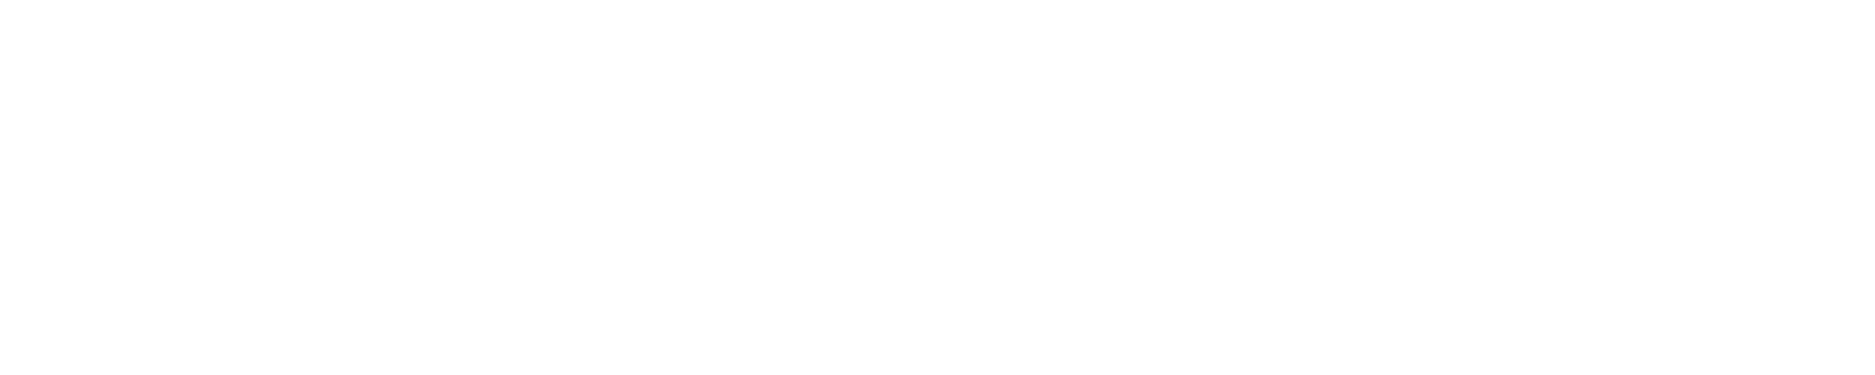

roi00021_sz30_M0


<IPython.core.display.Javascript object>


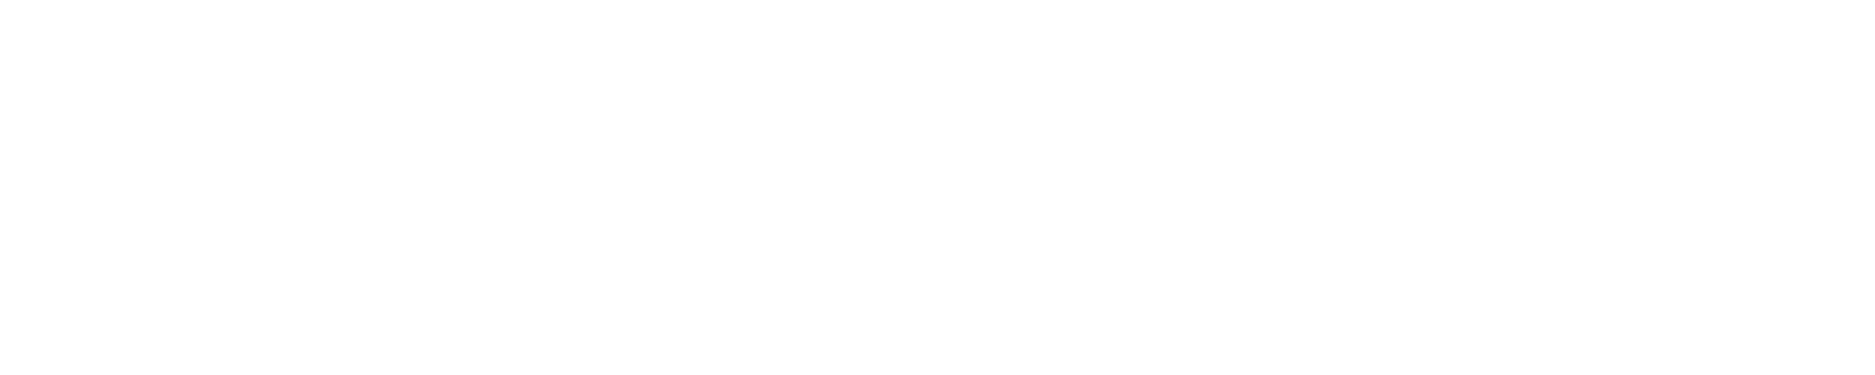

roi00022_sz30_M0


<IPython.core.display.Javascript object>


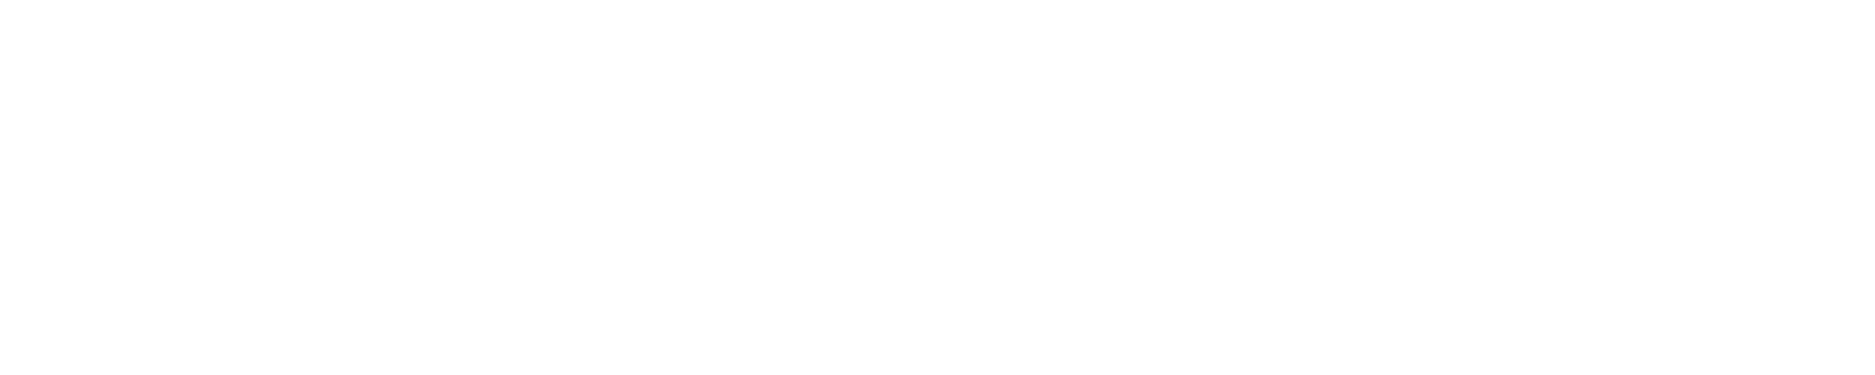

roi00023_sz30_M0


<IPython.core.display.Javascript object>


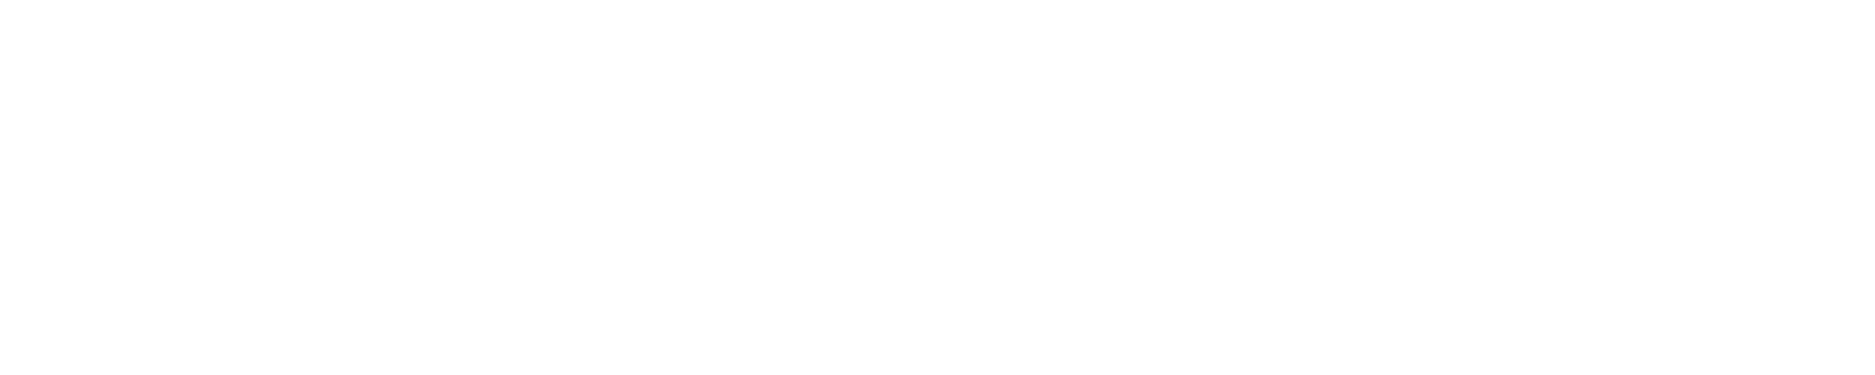

roi00029_sz30_M0


<IPython.core.display.Javascript object>


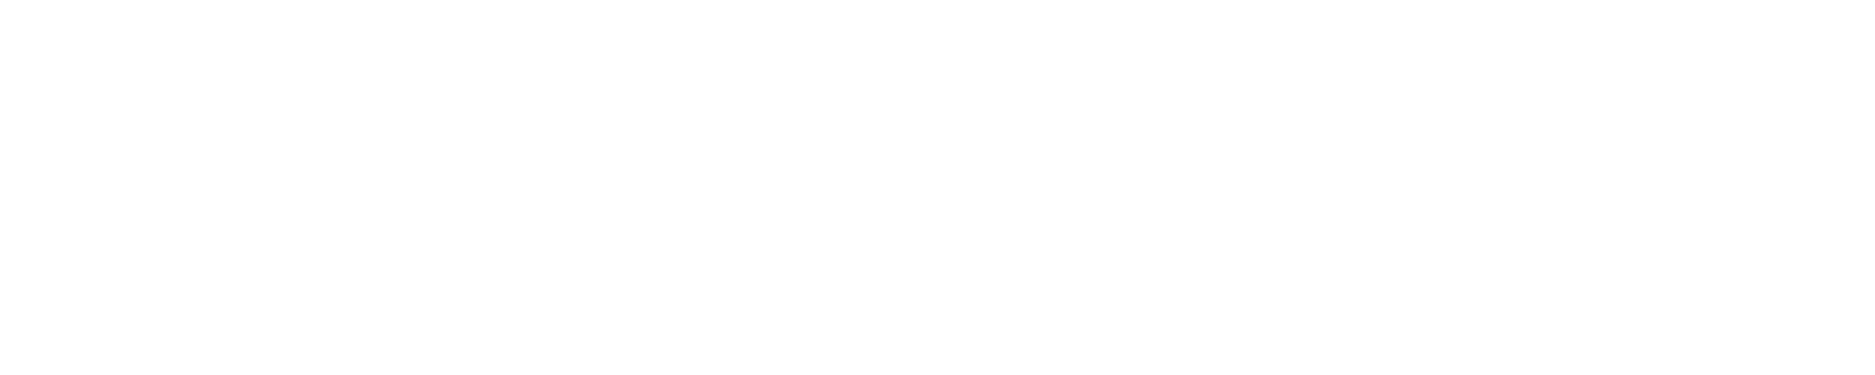

roi00031_sz30_M0


<IPython.core.display.Javascript object>


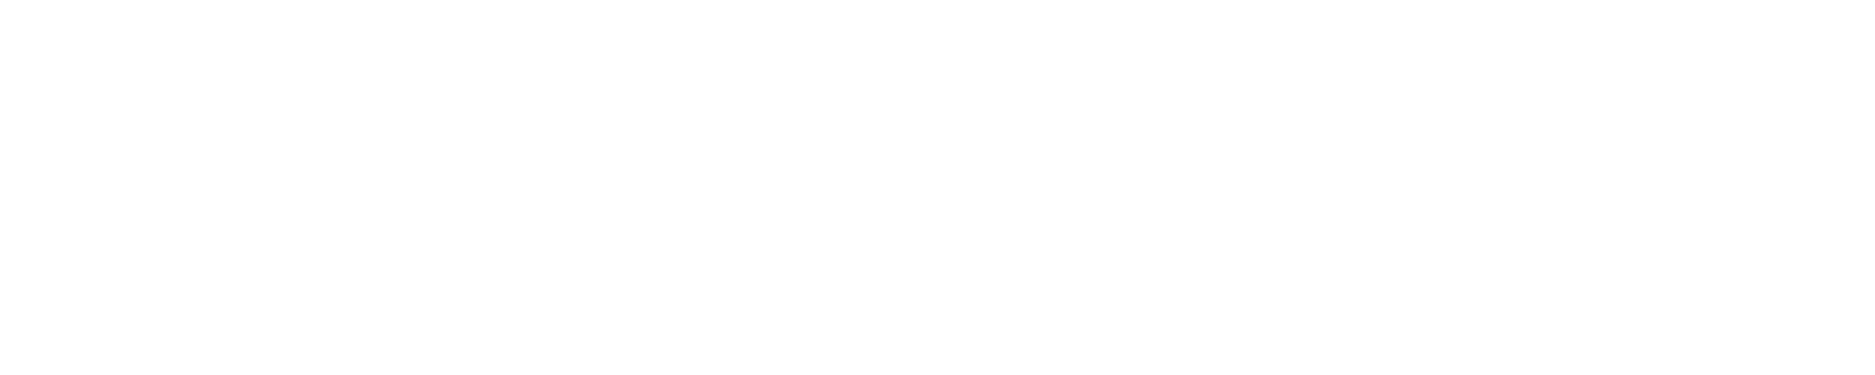

roi00033_sz30_M0


<IPython.core.display.Javascript object>


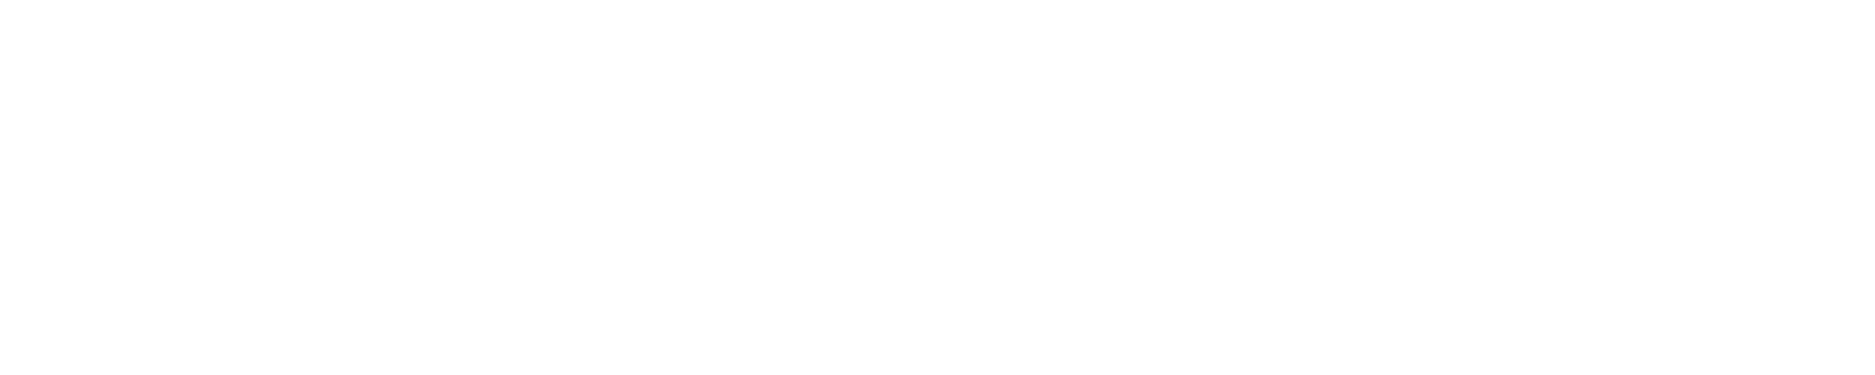

roi00034_sz30_M0


<IPython.core.display.Javascript object>


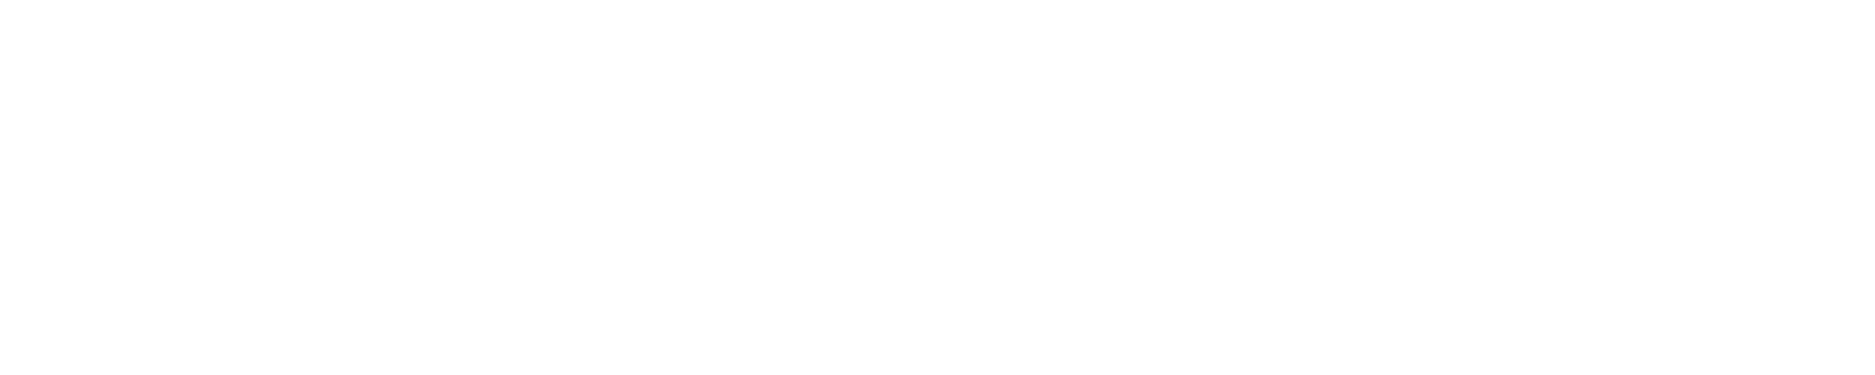

roi00059_sz30_M0


<IPython.core.display.Javascript object>


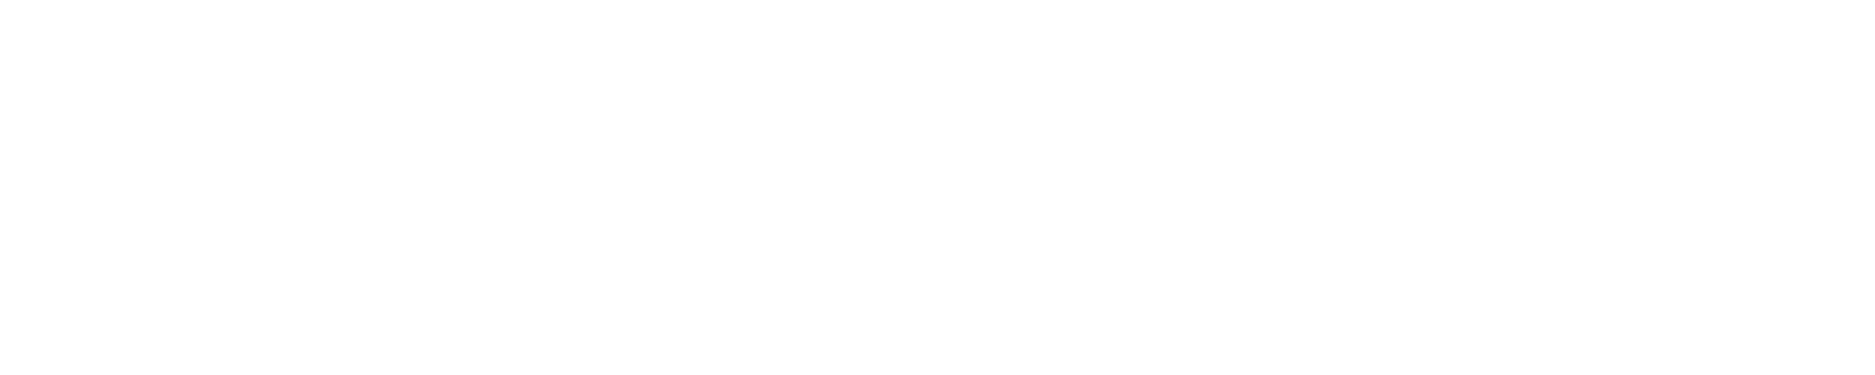

roi00065_sz30_M0


<IPython.core.display.Javascript object>


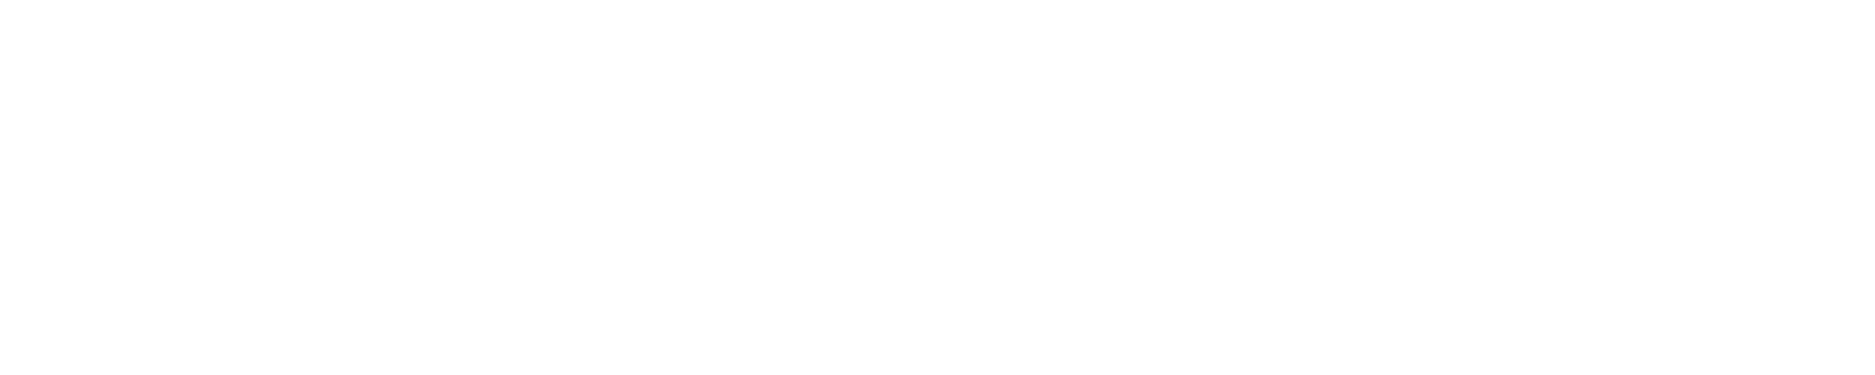

roi00111_sz30_M0


<IPython.core.display.Javascript object>


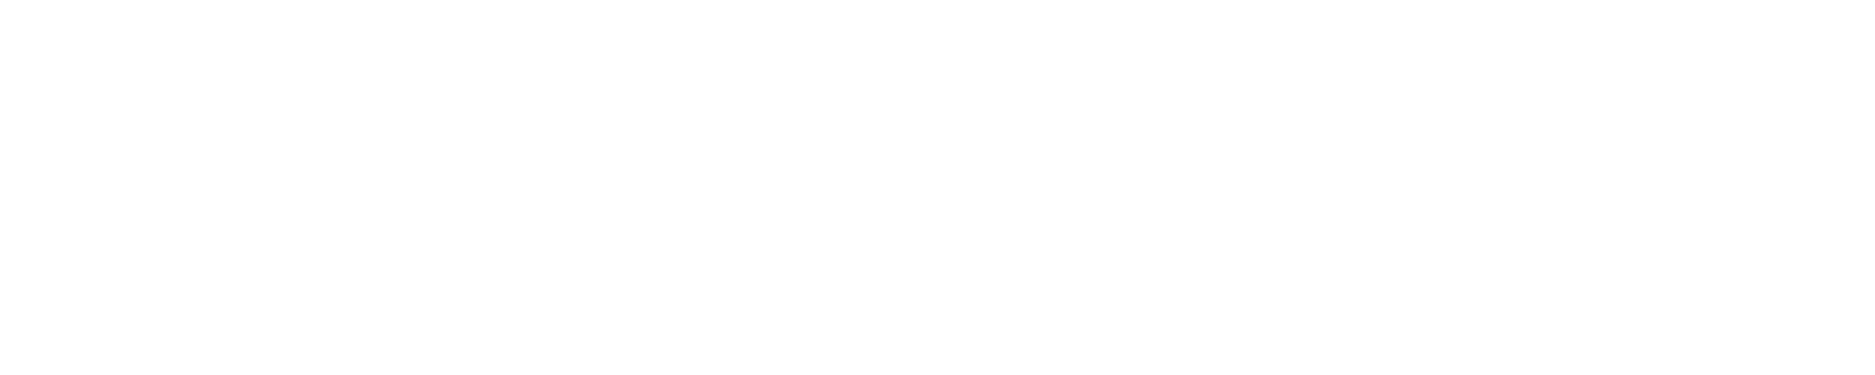

roi00128_sz30_M0


<IPython.core.display.Javascript object>


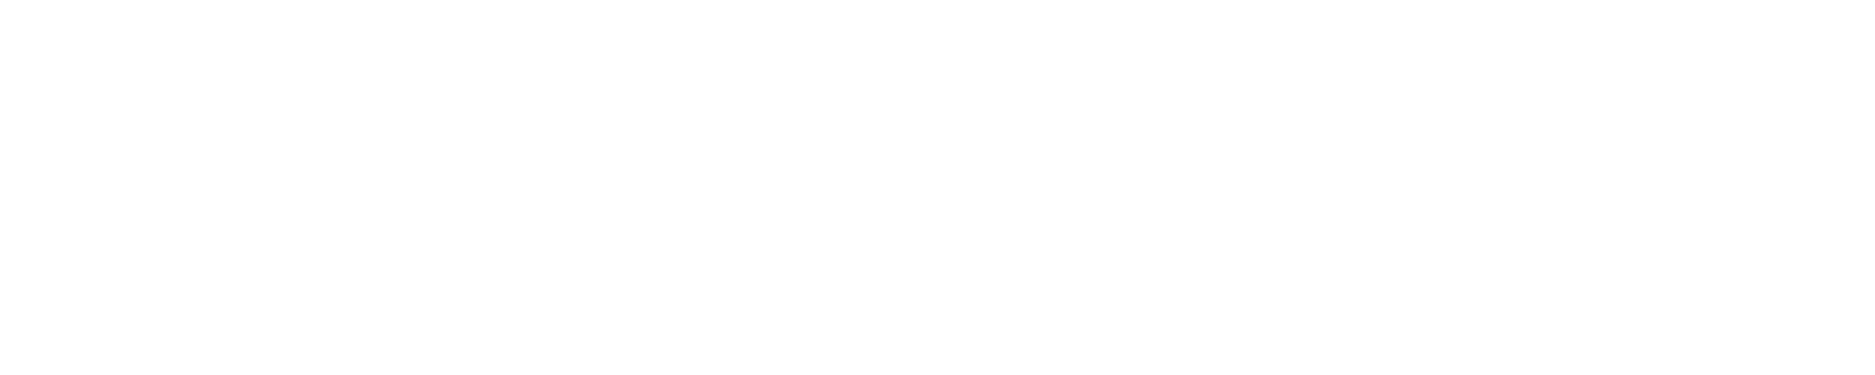

roi00143_sz30_M0


<IPython.core.display.Javascript object>


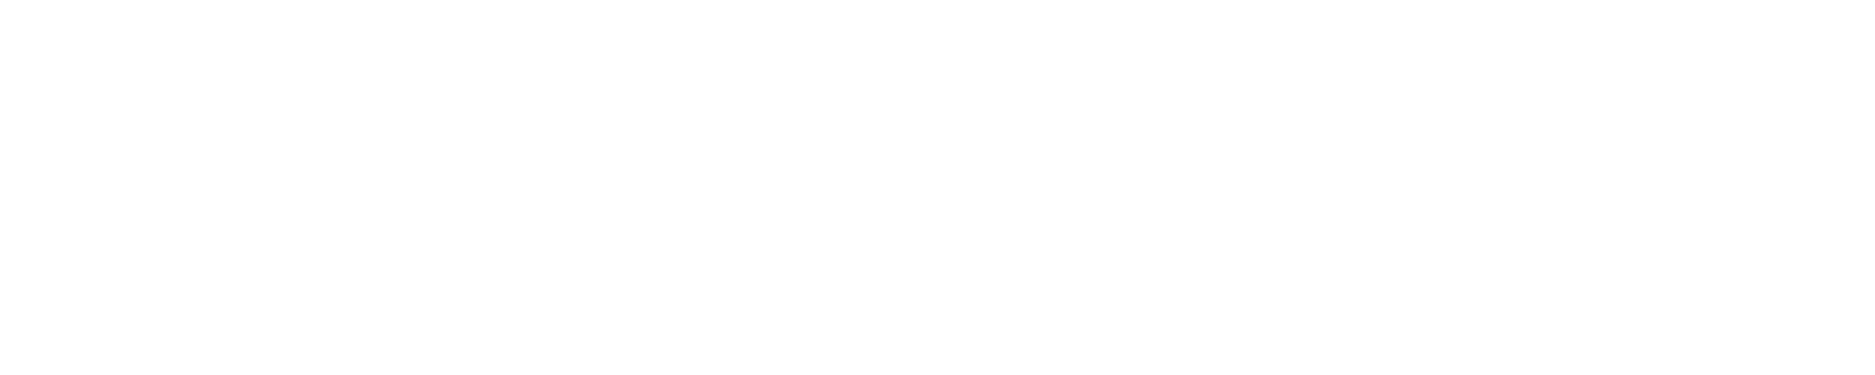

roi00148_sz30_M0


<IPython.core.display.Javascript object>


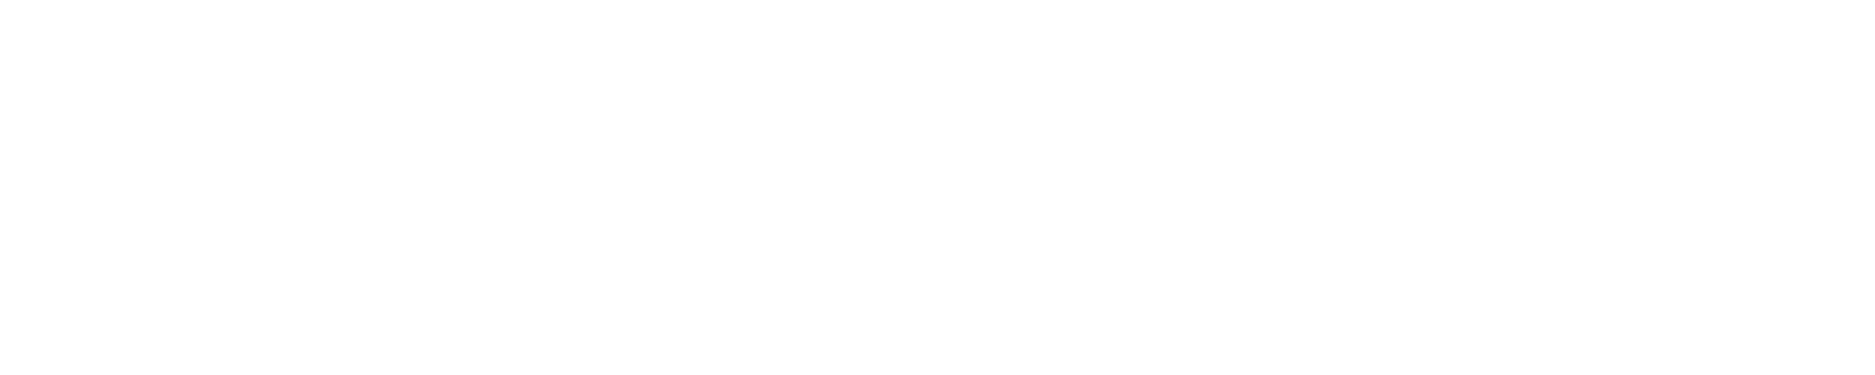

roi00175_sz30_M0


<IPython.core.display.Javascript object>


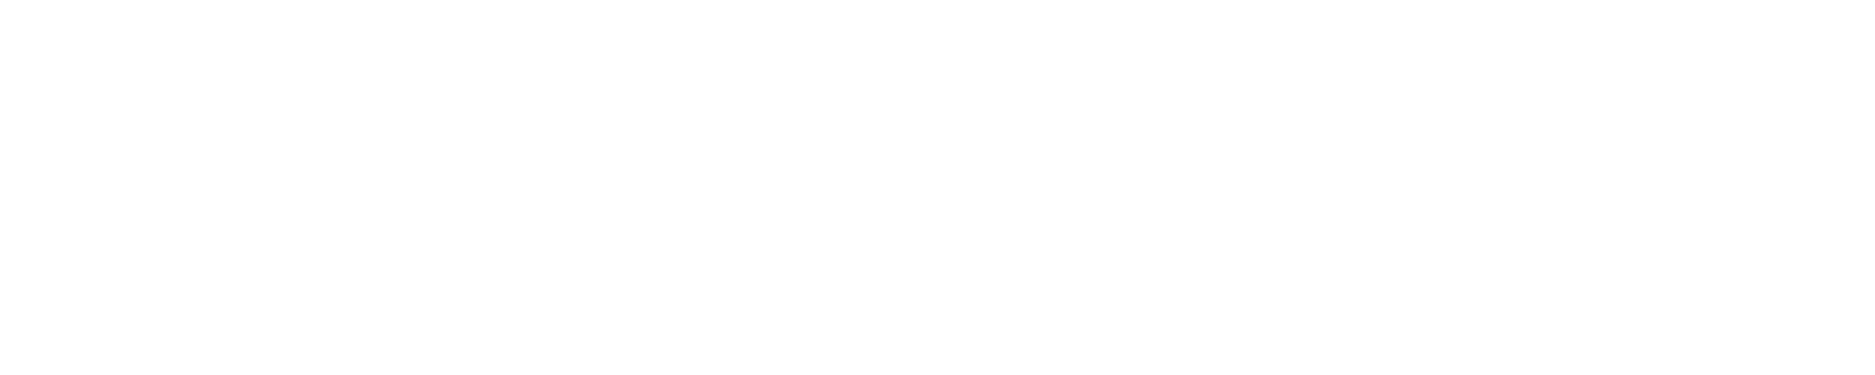

roi00183_sz30_M0


<IPython.core.display.Javascript object>


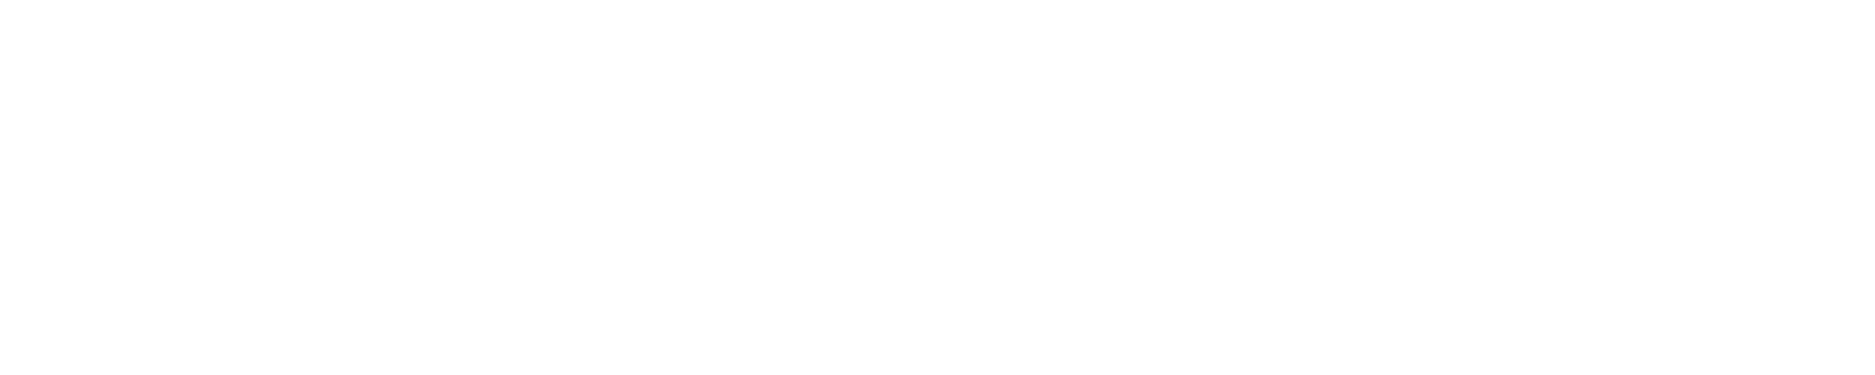

roi00202_sz30_M0


<IPython.core.display.Javascript object>


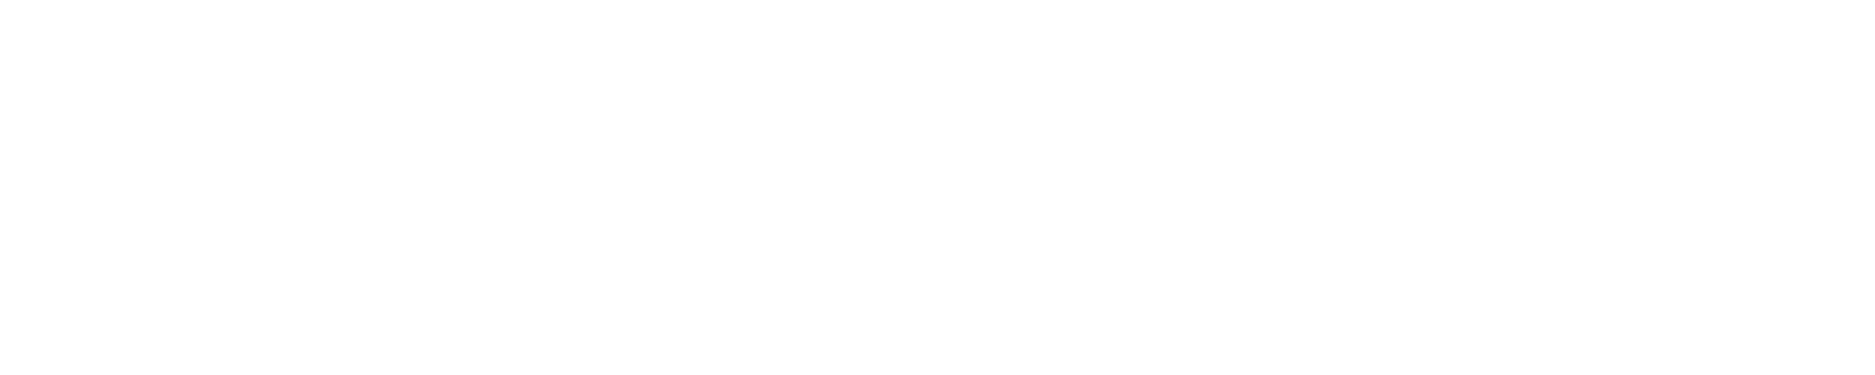

roi00203_sz30_M0


<IPython.core.display.Javascript object>


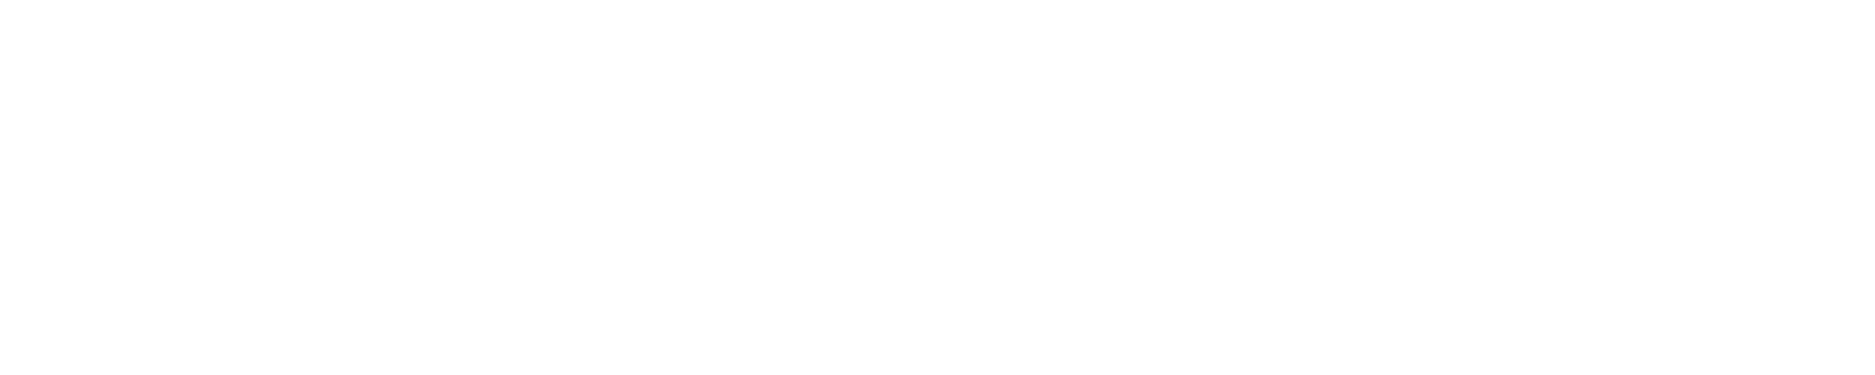

roi00206_sz30_M0


<IPython.core.display.Javascript object>


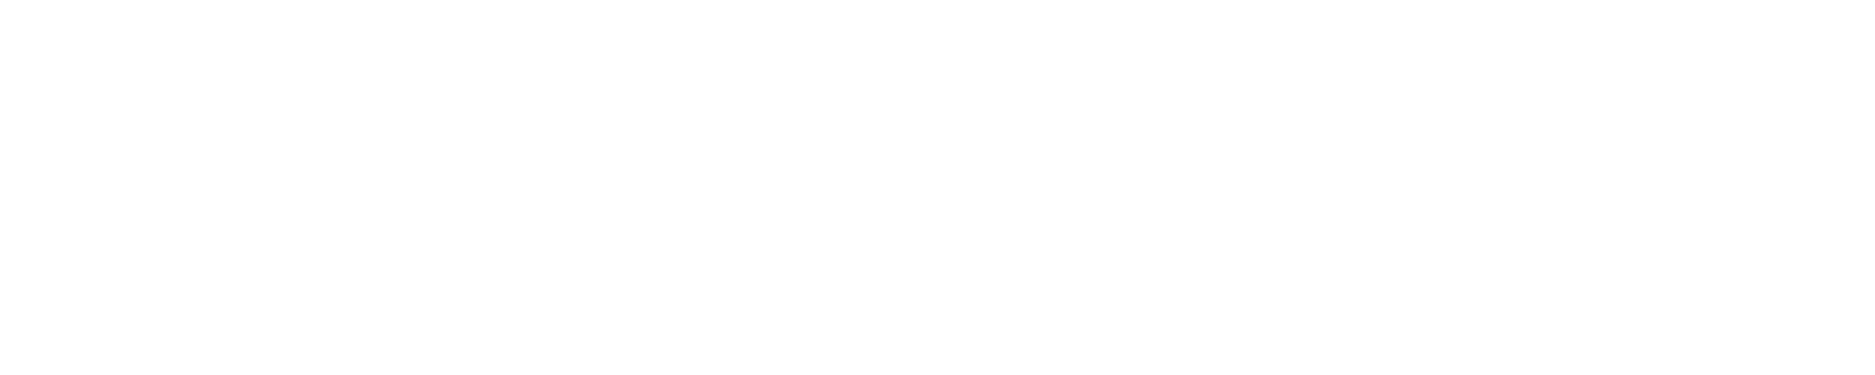

roi00237_sz30_M0


<IPython.core.display.Javascript object>


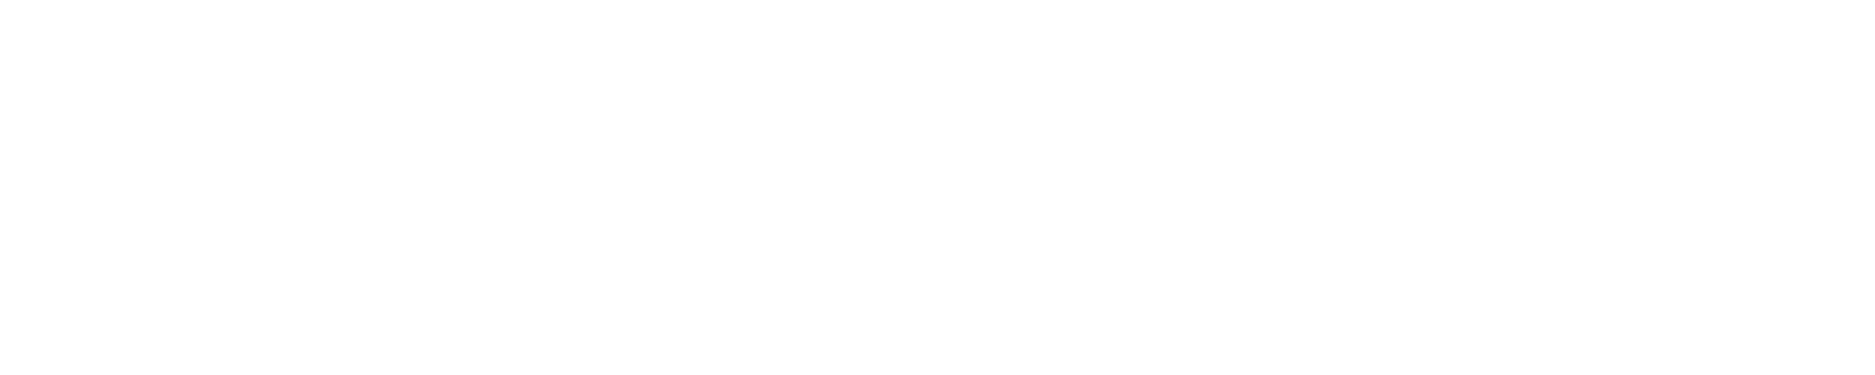

roi00283_sz30_M0


<IPython.core.display.Javascript object>


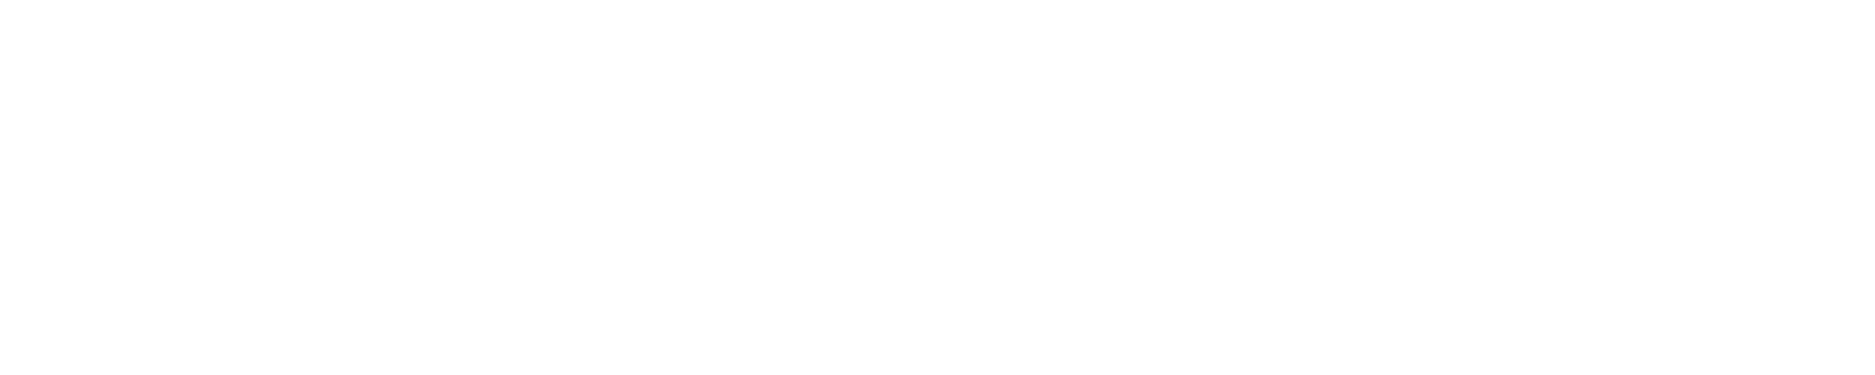

roi00285_sz30_M0


<IPython.core.display.Javascript object>


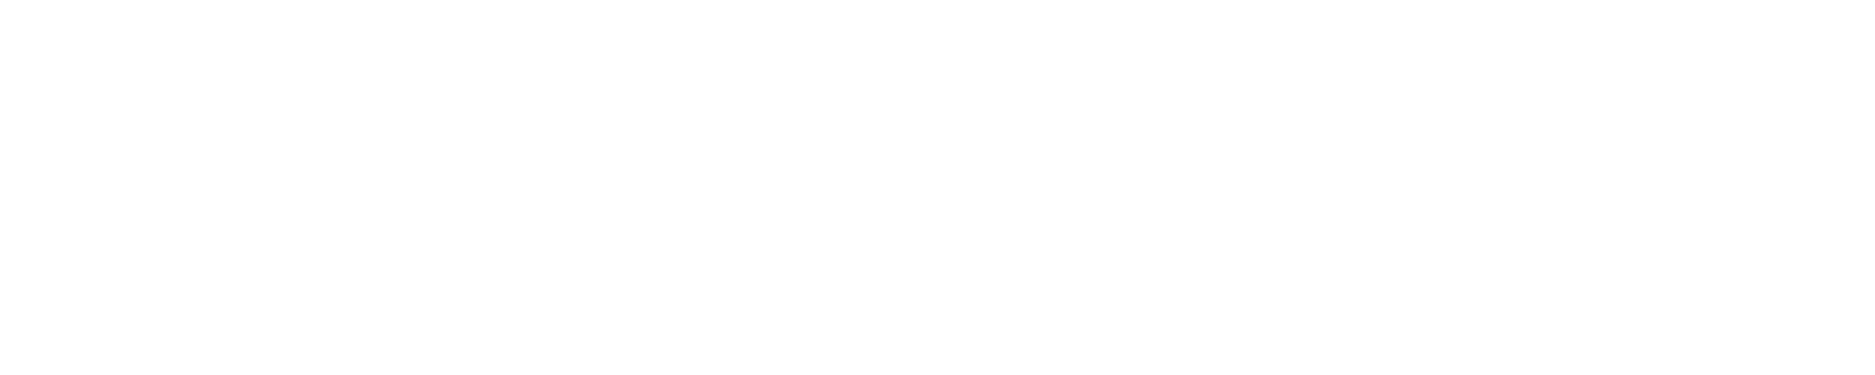

roi00286_sz30_M0


<IPython.core.display.Javascript object>


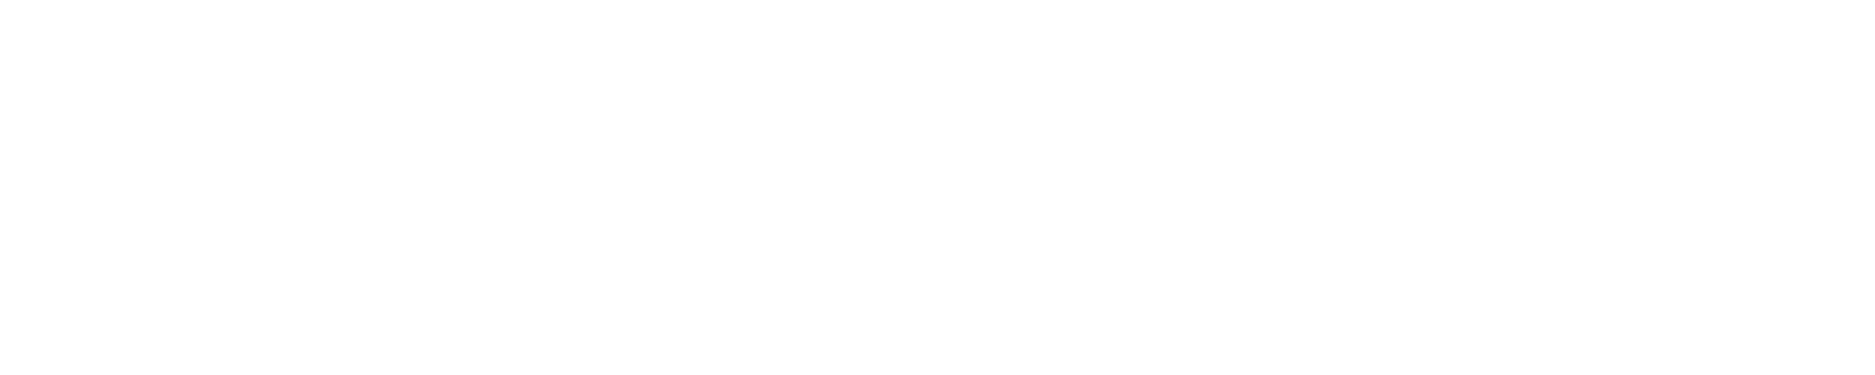

roi00306_sz30_M0


<IPython.core.display.Javascript object>


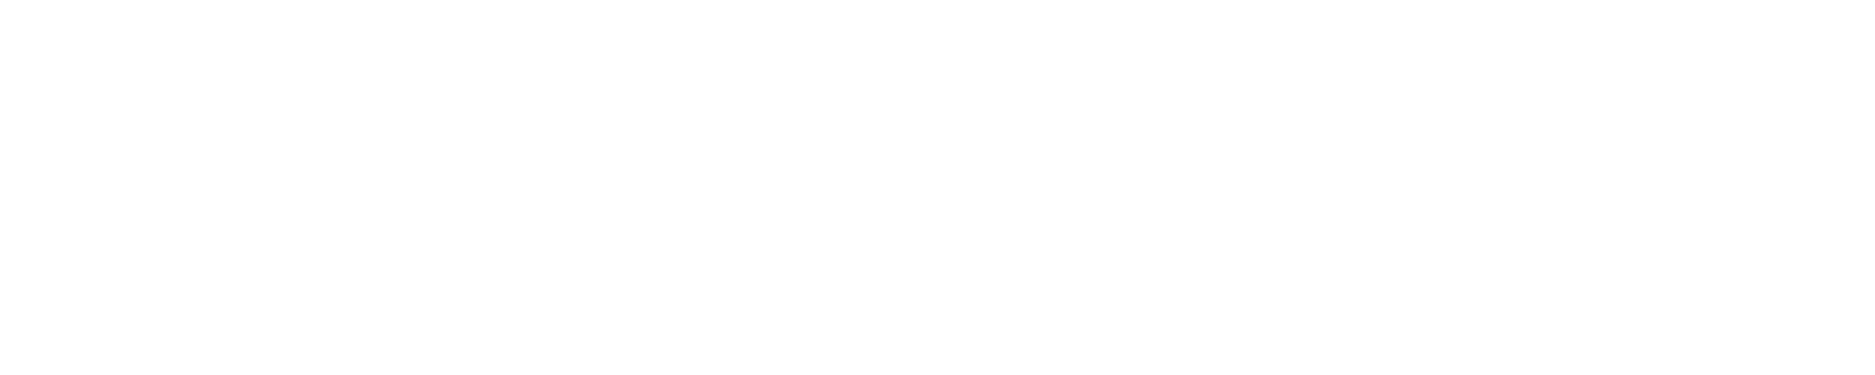

roi00310_sz30_M0
('...overblown on right edge', (1081, 1920))
('...trimming 0 off bottom', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...overblown on right edge', (1081, 1920))
('...trimming 0 off bottom', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...overblown on right edge', (1081, 1920))
('...trimming 0 off bottom', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...overblown on right edge', (1081, 1920))
('...trimming 0 off bottom', (1080, 1920))
('...trimming 0 off bottom', (1080, 1921))
('...trimming 0 off right', (1080, 1920))
('...trimming 0 off bottom', (1080, 

<IPython.core.display.Javascript object>


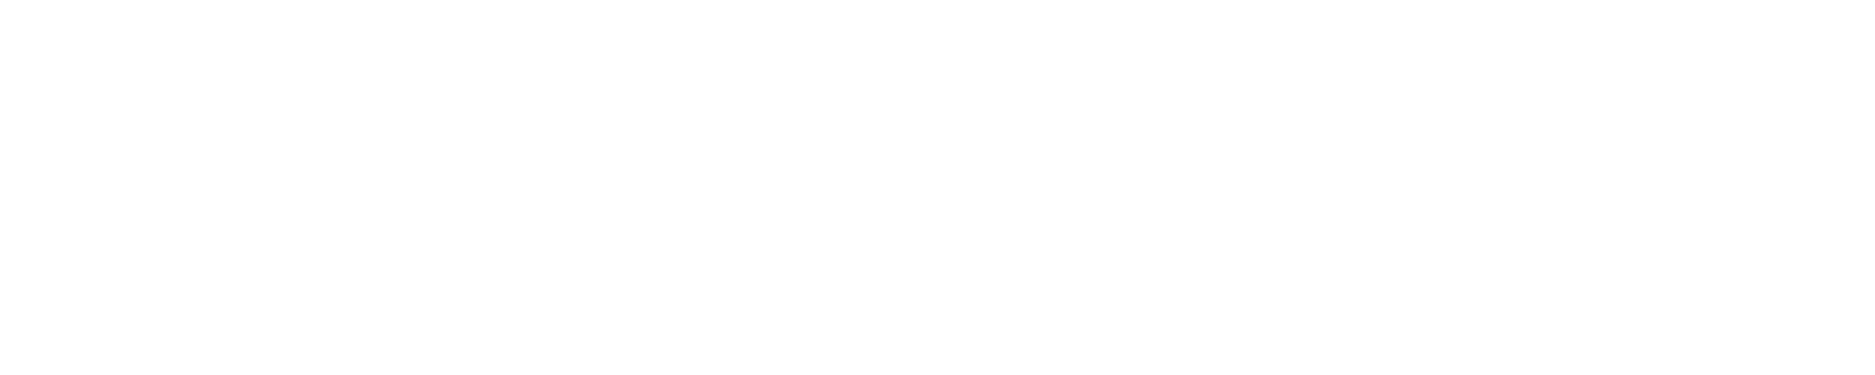

roi00017_sz30_M106


<IPython.core.display.Javascript object>


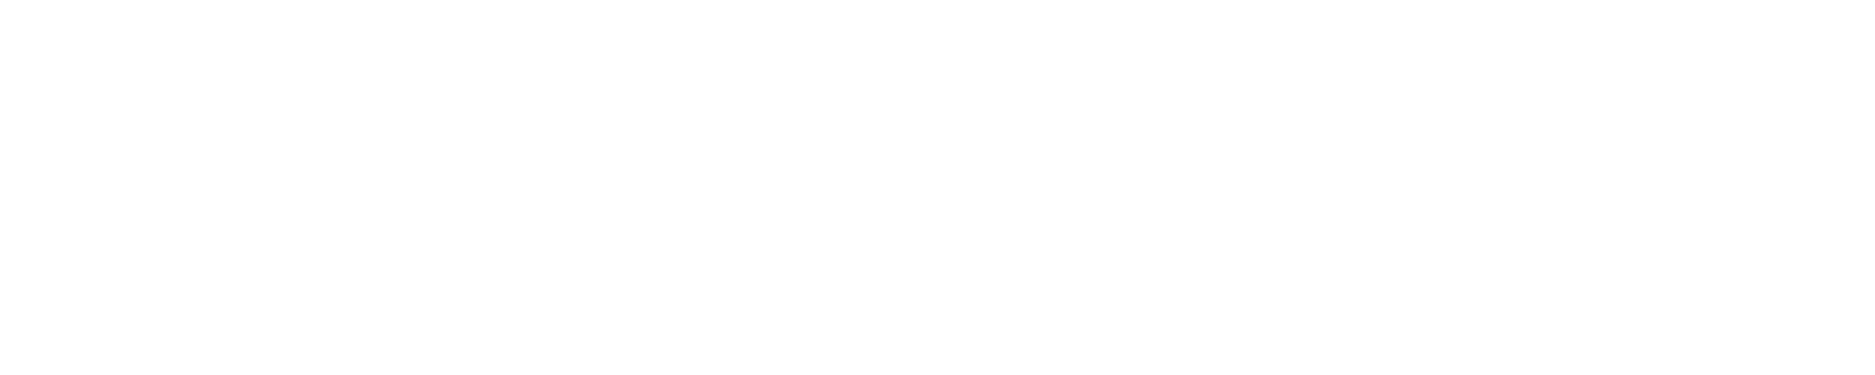

roi00021_sz30_M106


<IPython.core.display.Javascript object>


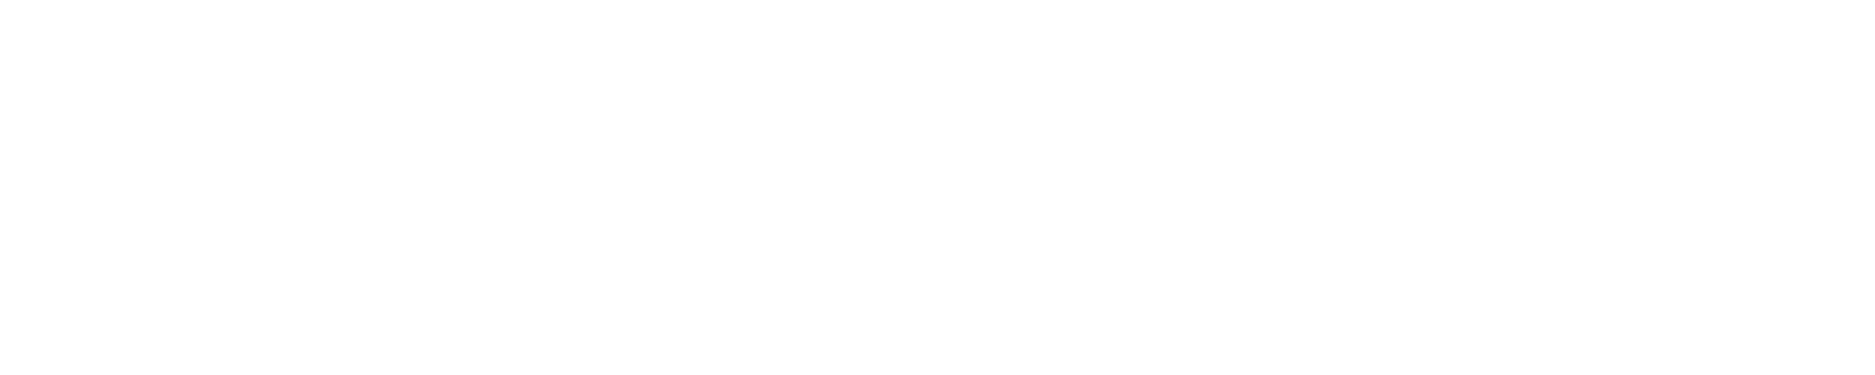

roi00022_sz30_M106


<IPython.core.display.Javascript object>


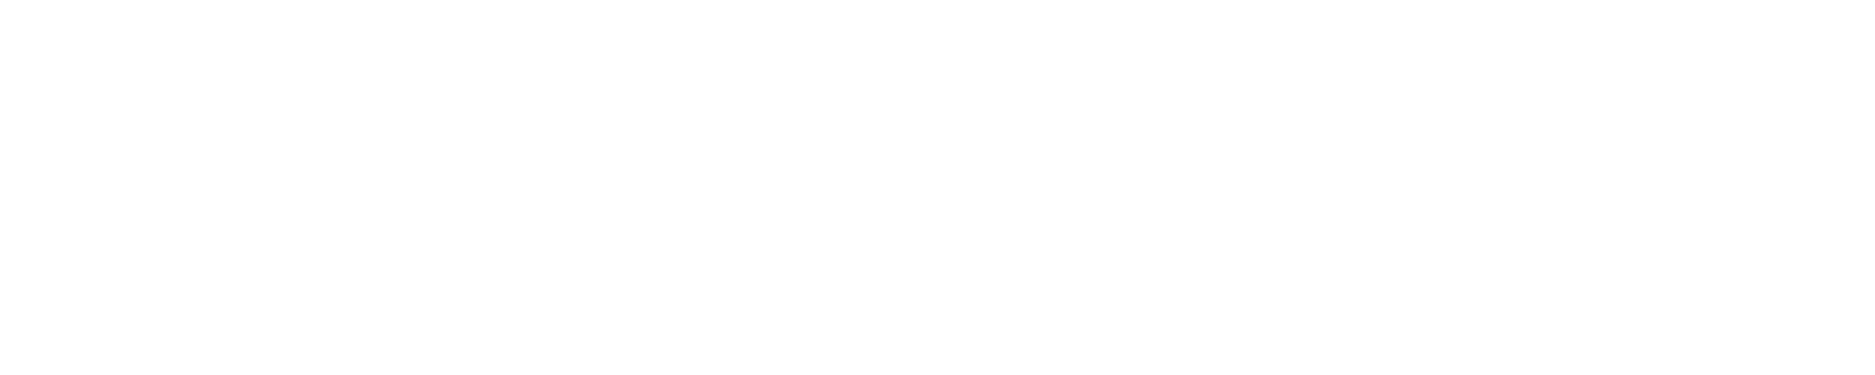

roi00023_sz30_M106


<IPython.core.display.Javascript object>


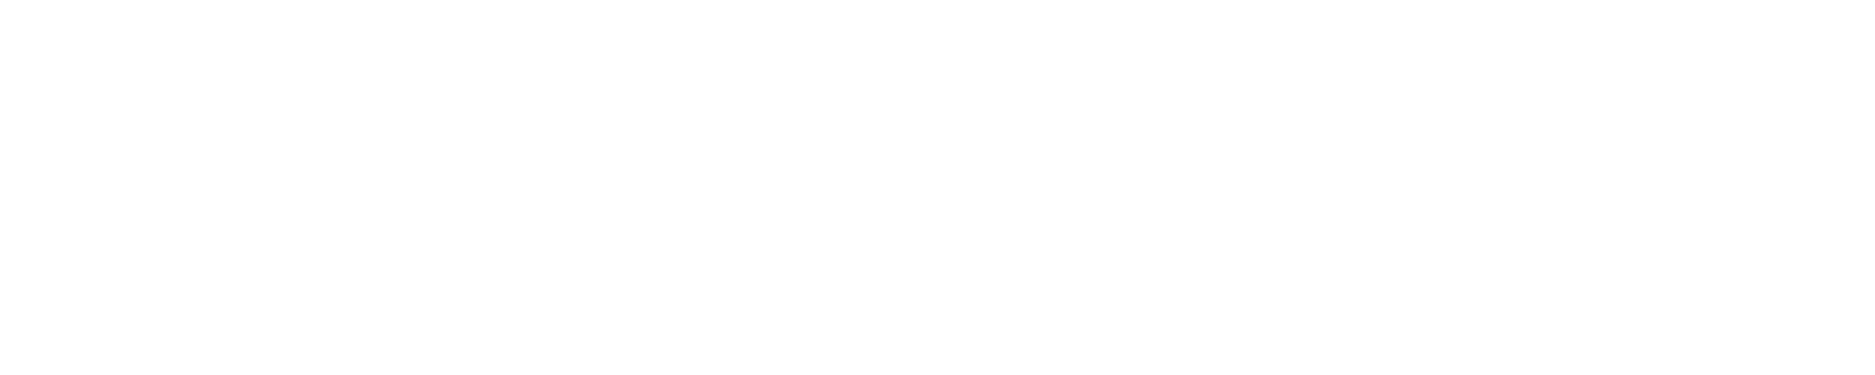

roi00029_sz30_M106


<IPython.core.display.Javascript object>


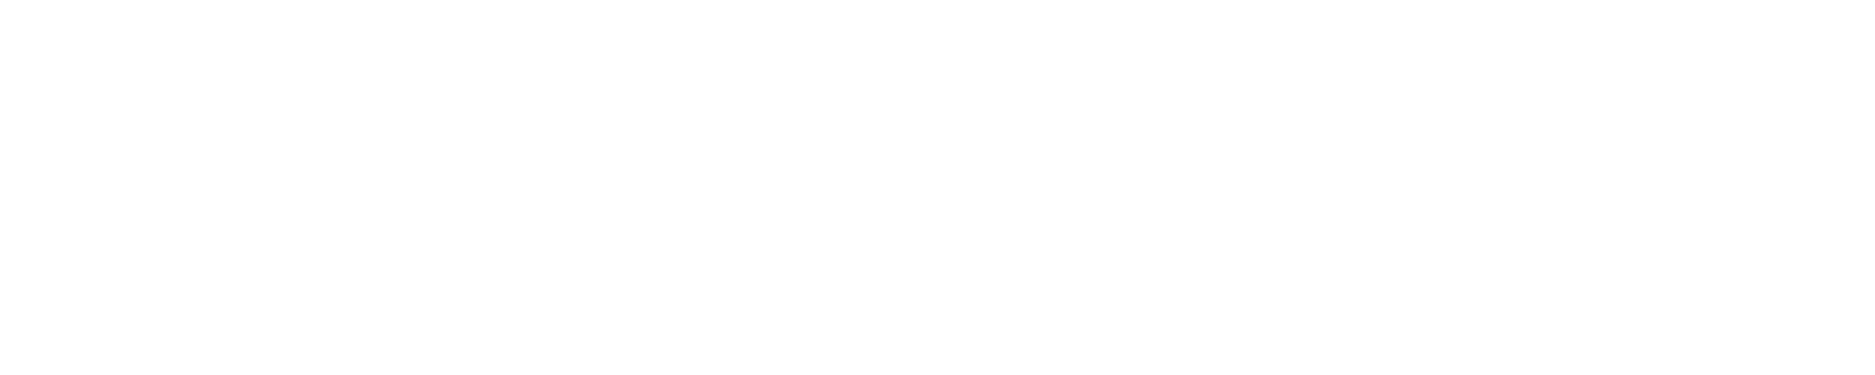

roi00031_sz30_M106


<IPython.core.display.Javascript object>


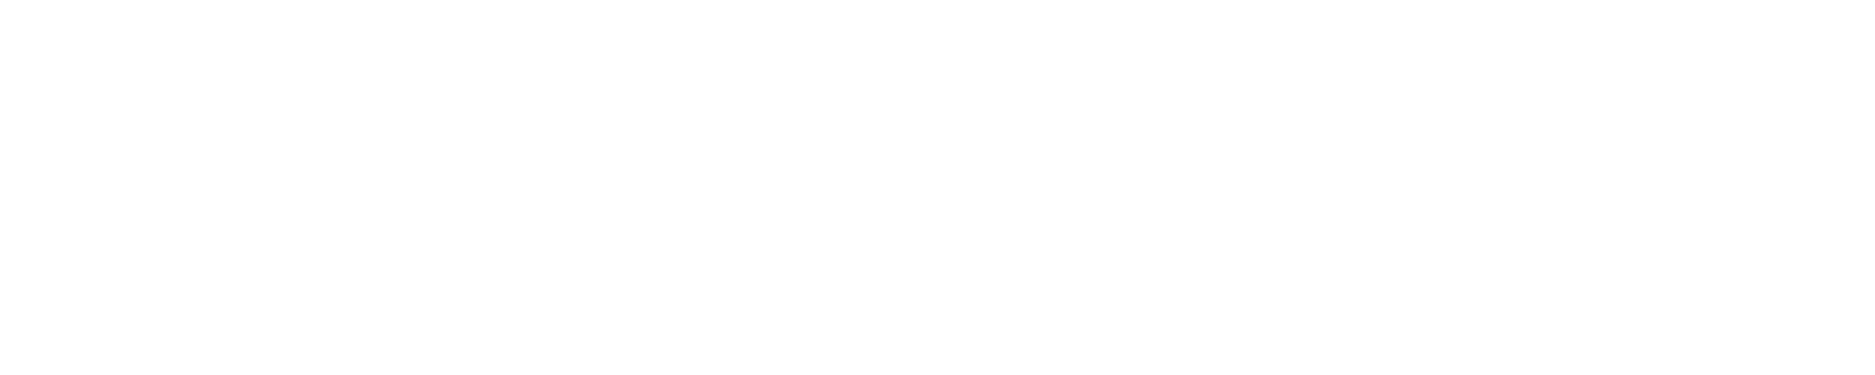

roi00033_sz30_M106


<IPython.core.display.Javascript object>


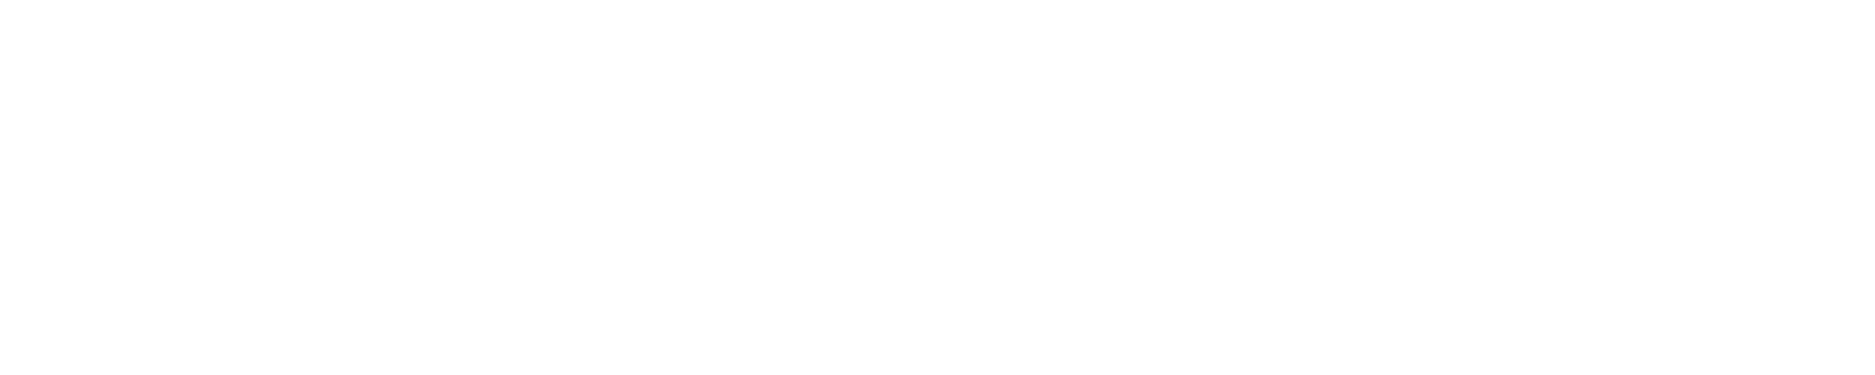

roi00034_sz30_M106


<IPython.core.display.Javascript object>


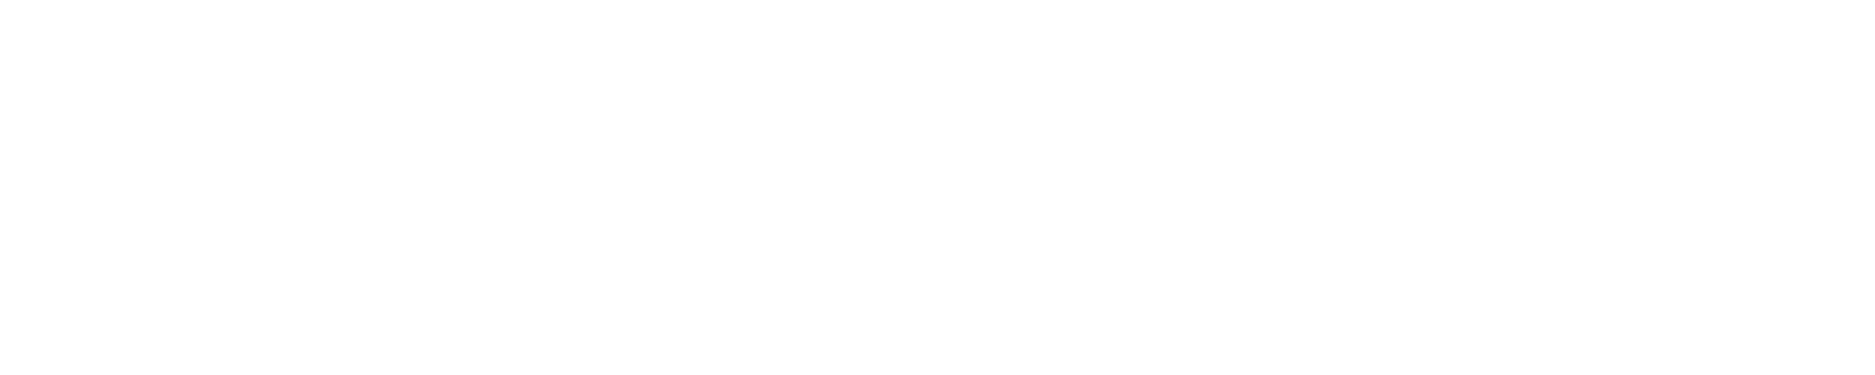

roi00059_sz30_M106


<IPython.core.display.Javascript object>


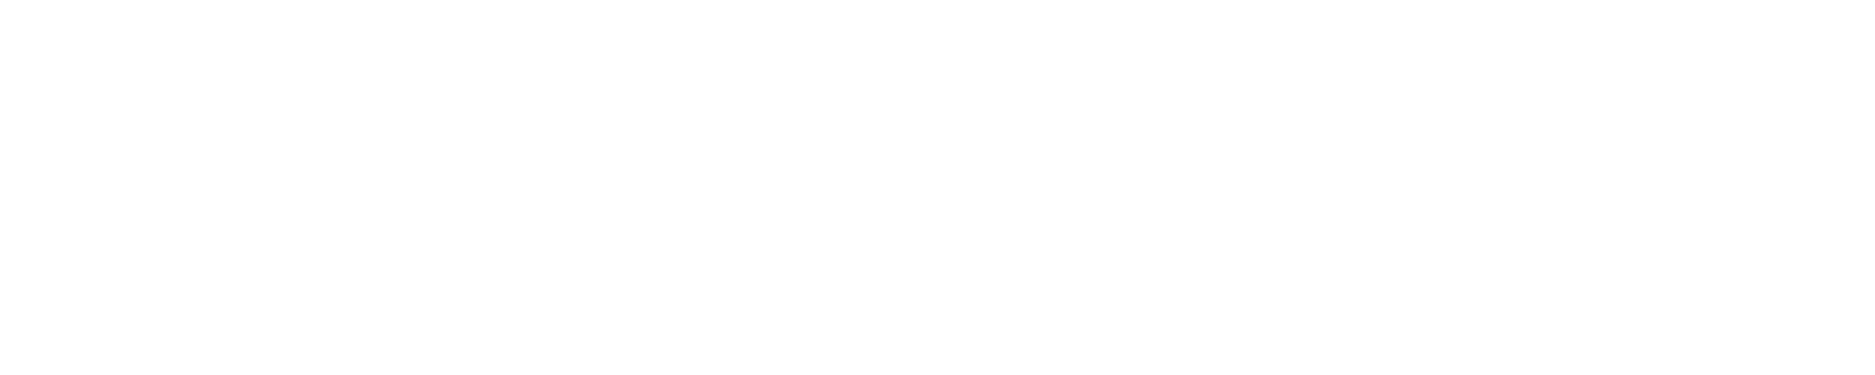

roi00065_sz30_M106


<IPython.core.display.Javascript object>


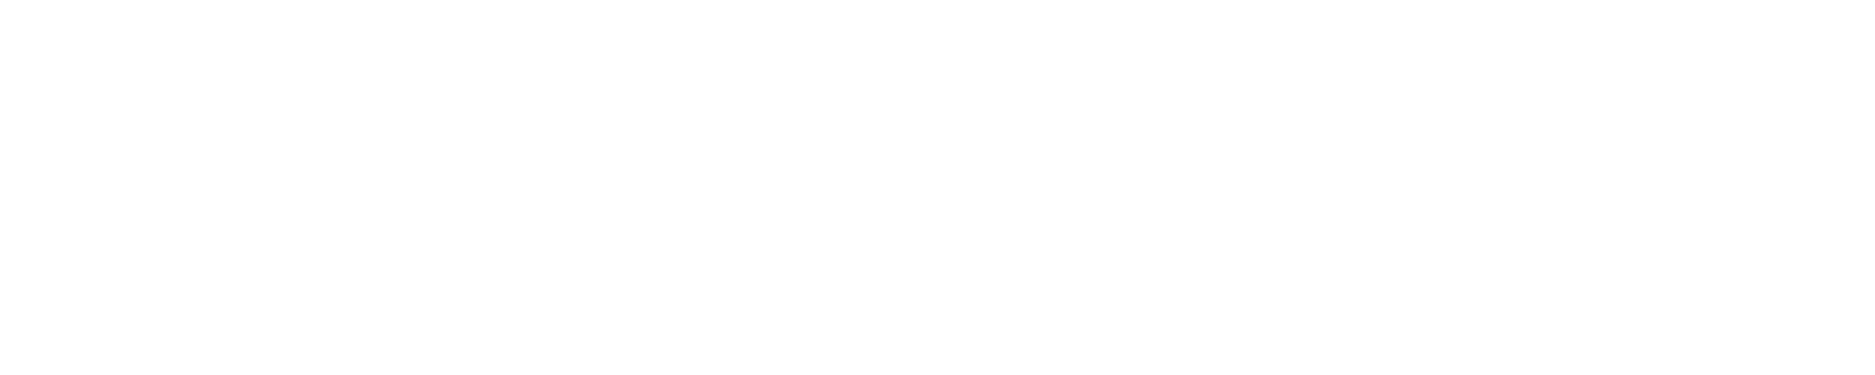

roi00111_sz30_M106


<IPython.core.display.Javascript object>


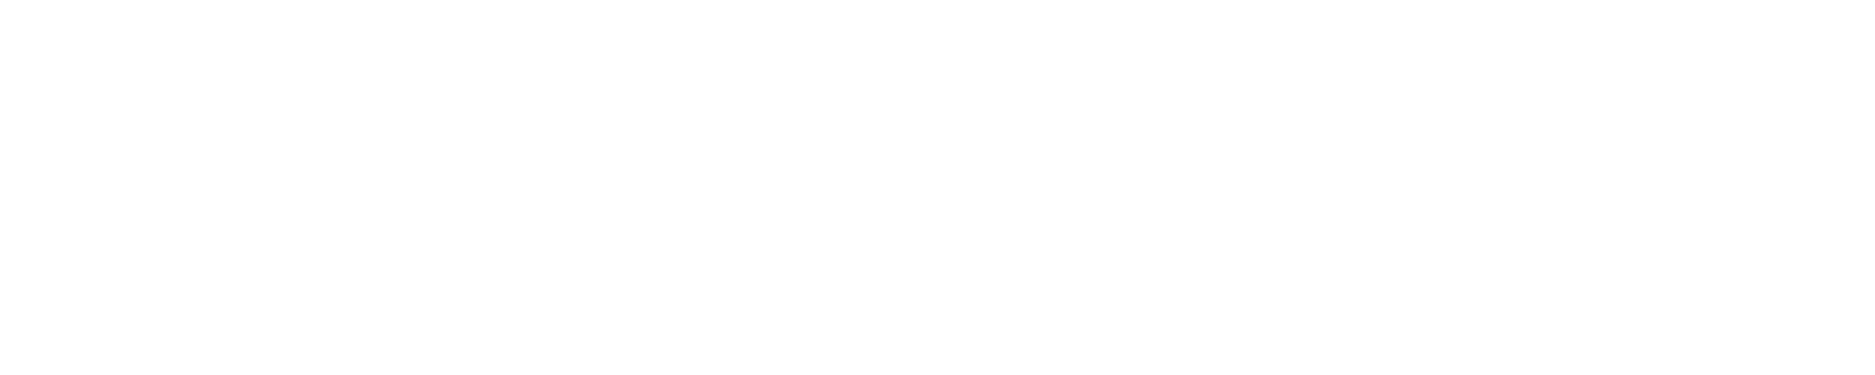

roi00128_sz30_M106


<IPython.core.display.Javascript object>


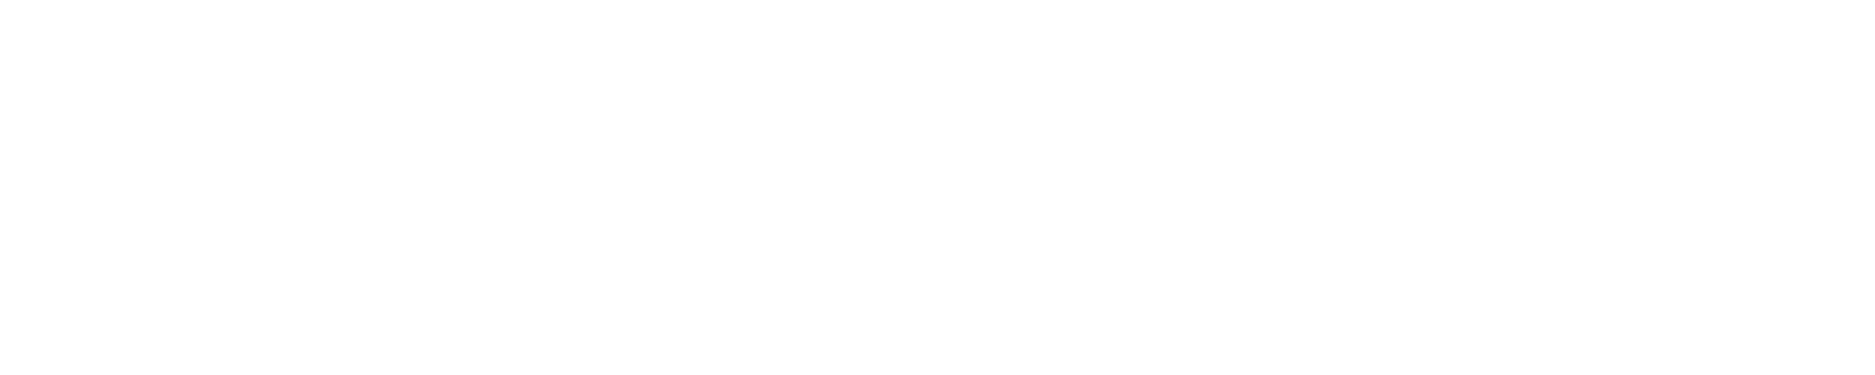

roi00143_sz30_M106


<IPython.core.display.Javascript object>


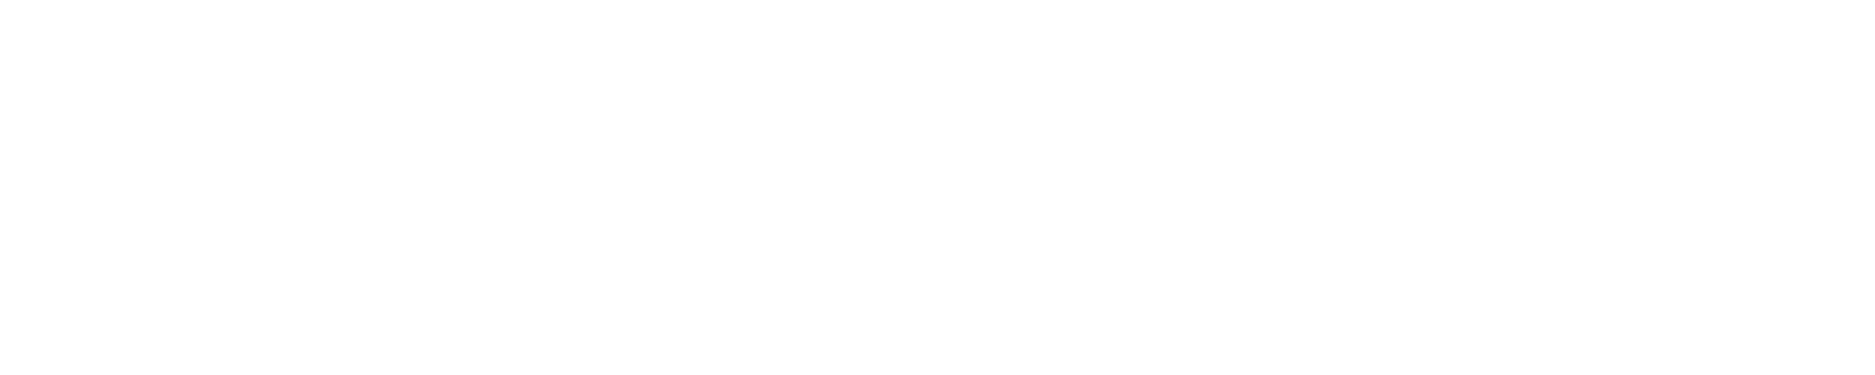

roi00148_sz30_M106


<IPython.core.display.Javascript object>


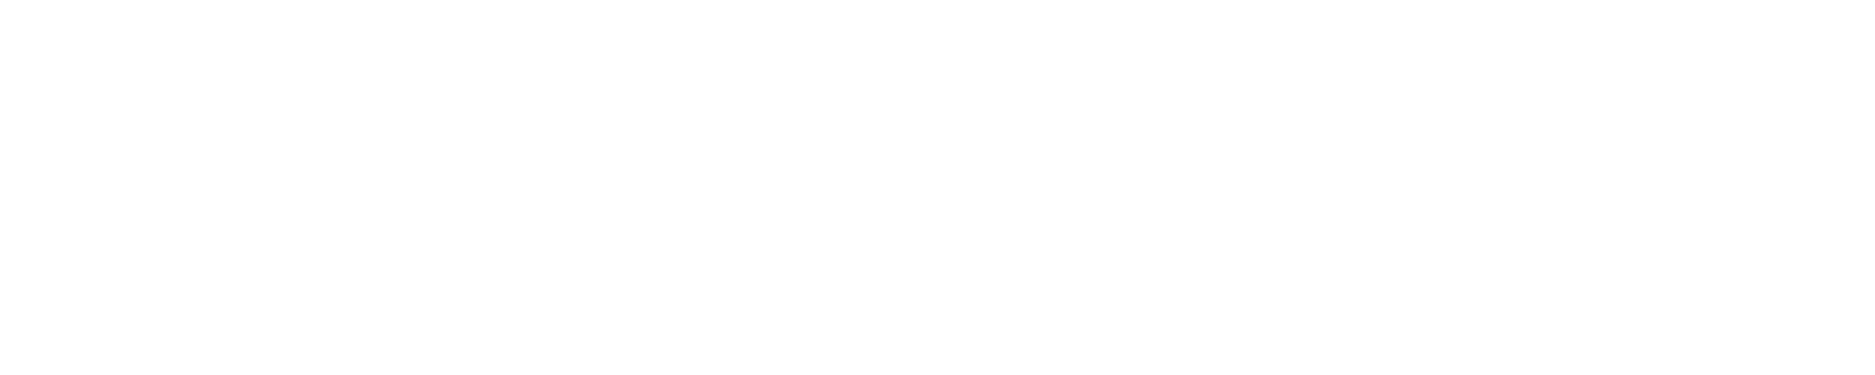

roi00175_sz30_M106


<IPython.core.display.Javascript object>


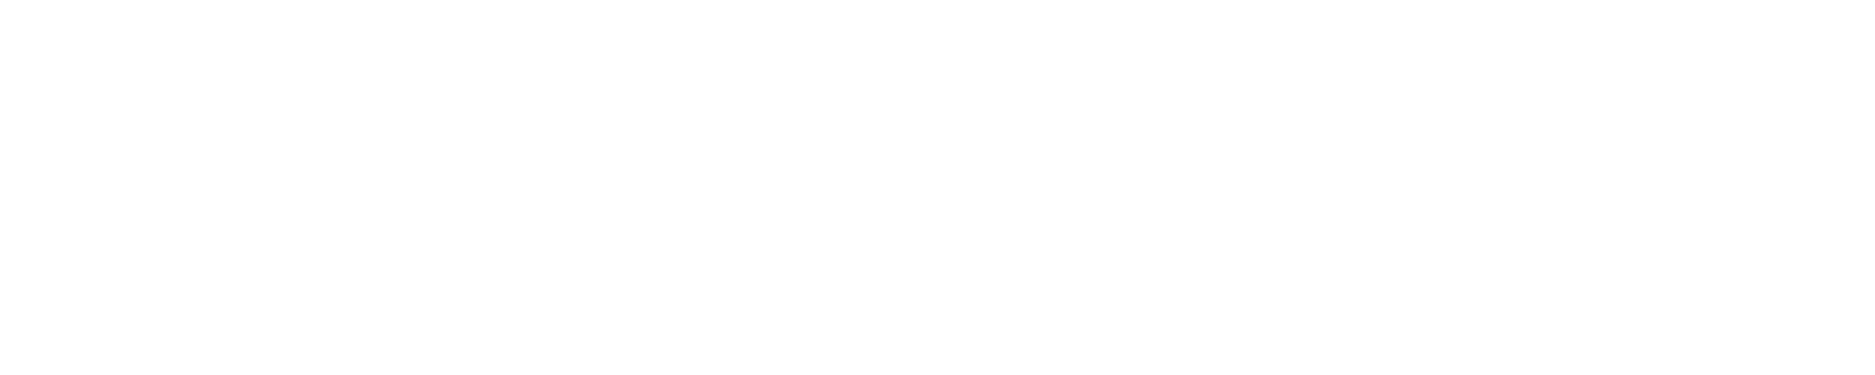

roi00183_sz30_M106


<IPython.core.display.Javascript object>


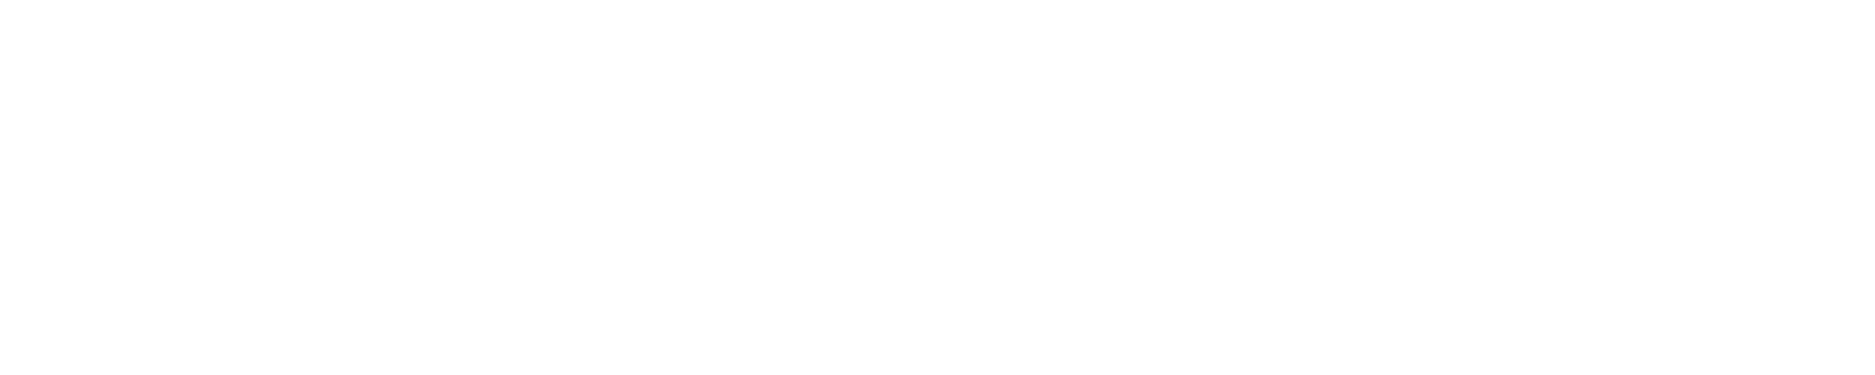

roi00202_sz30_M106


<IPython.core.display.Javascript object>


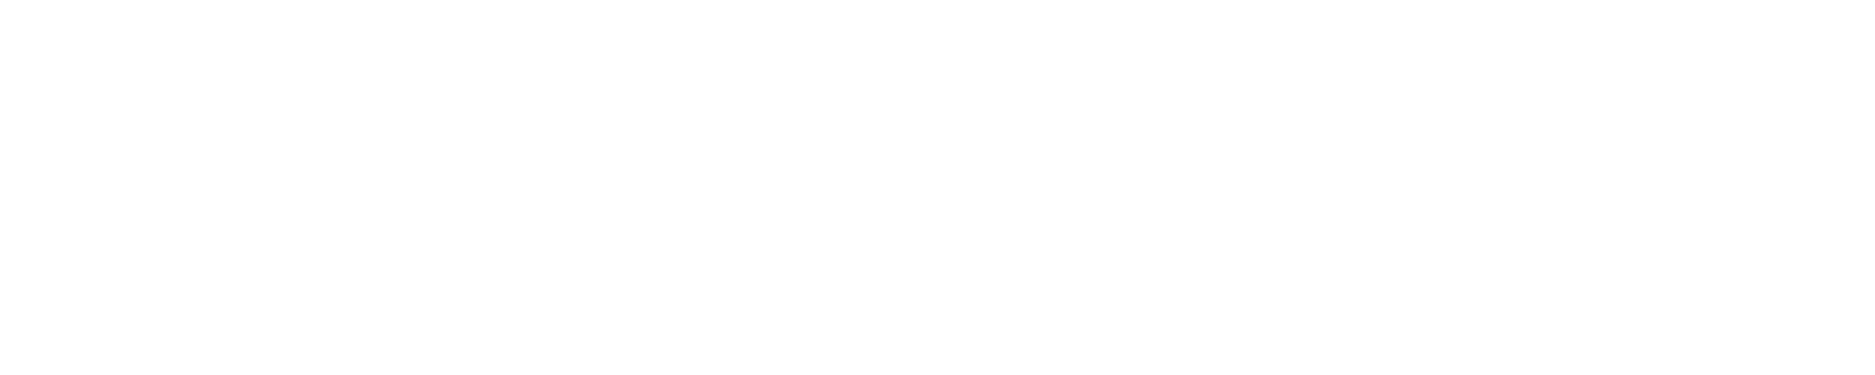

roi00203_sz30_M106


<IPython.core.display.Javascript object>


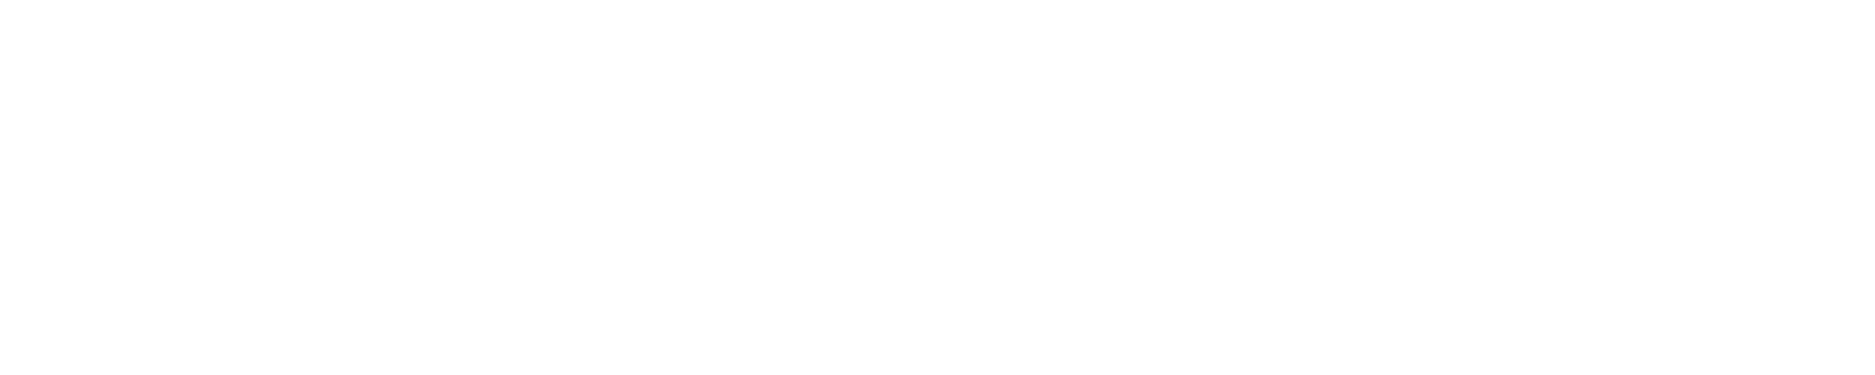

roi00206_sz30_M106


<IPython.core.display.Javascript object>


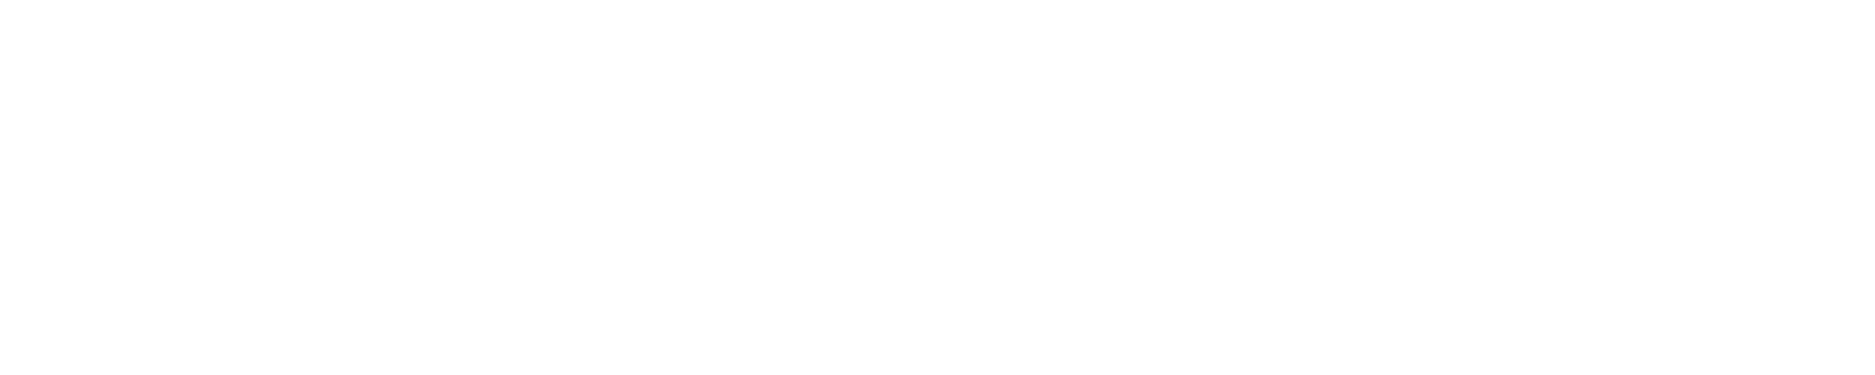

roi00237_sz30_M106


<IPython.core.display.Javascript object>


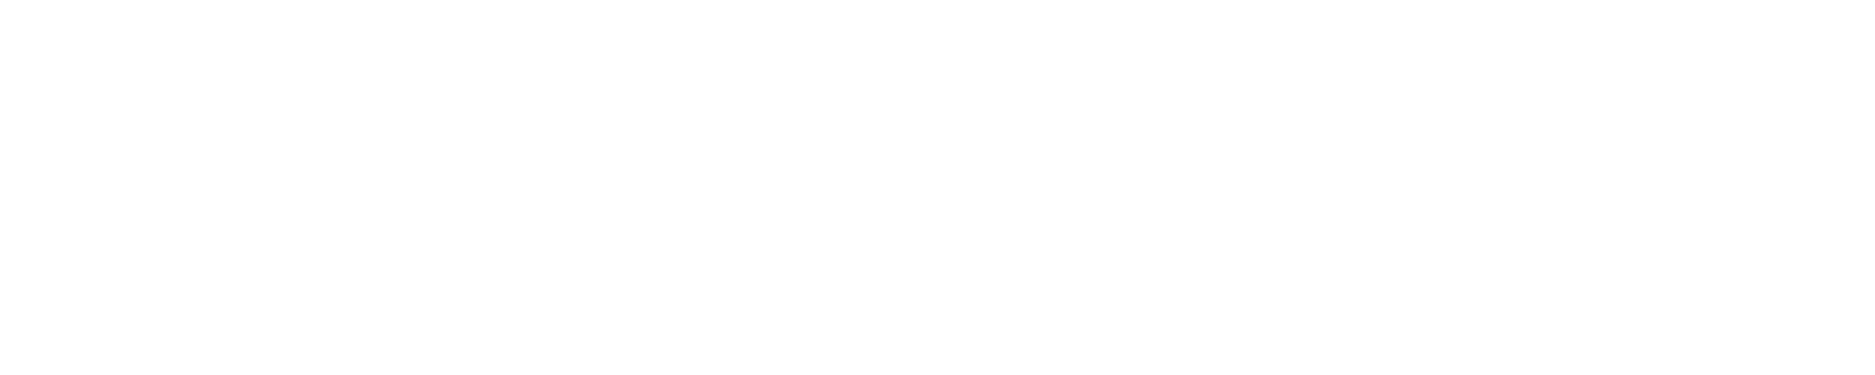

roi00283_sz30_M106


<IPython.core.display.Javascript object>


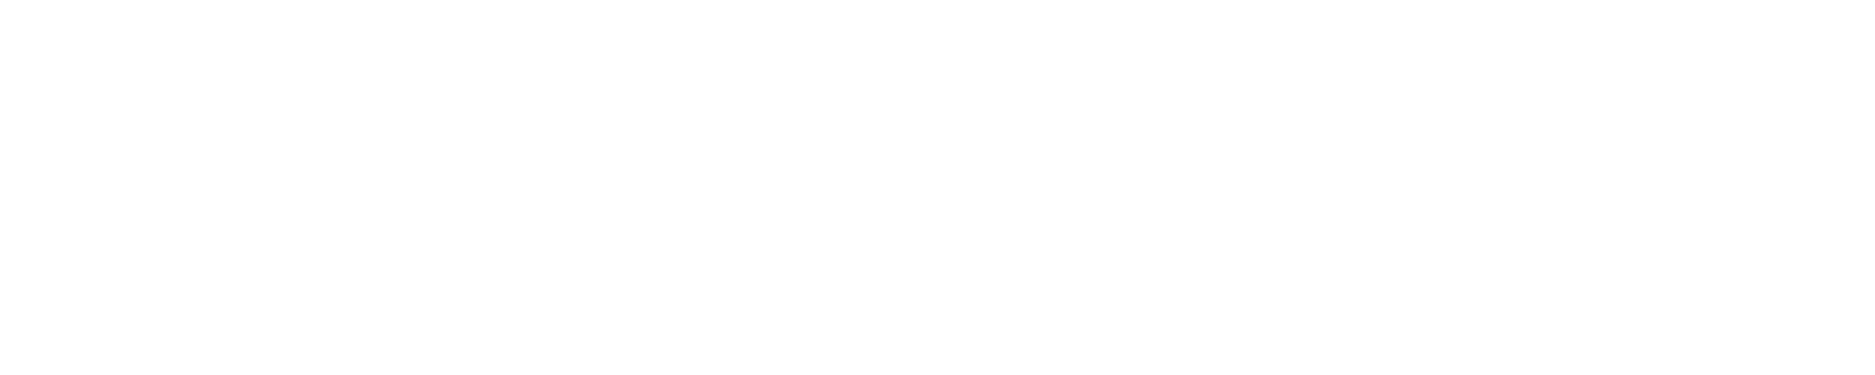

roi00285_sz30_M106


<IPython.core.display.Javascript object>


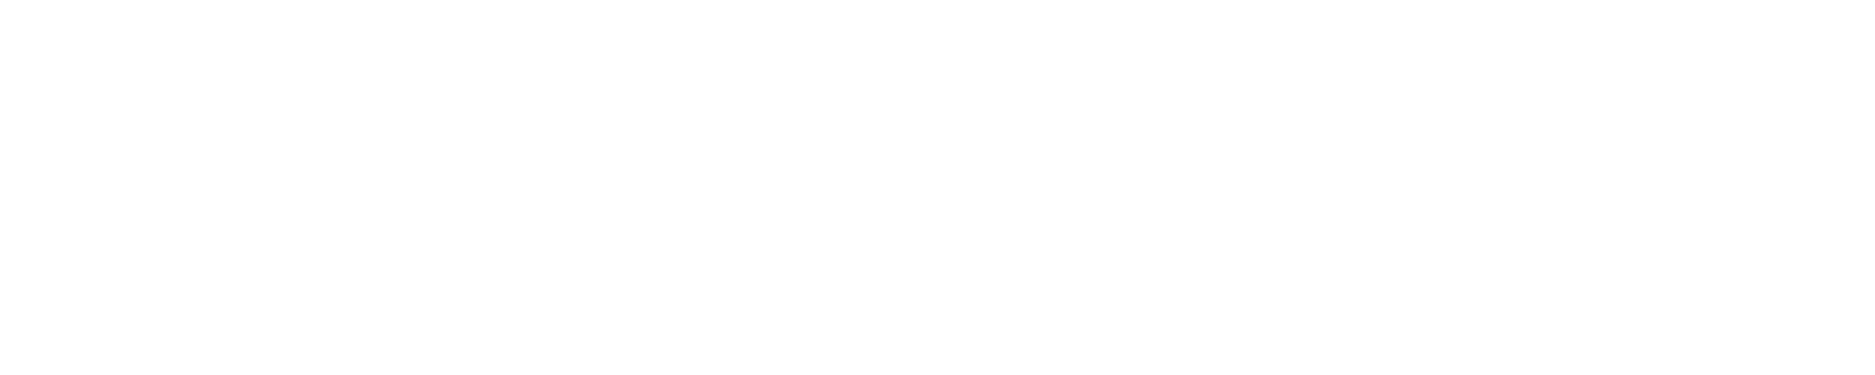

roi00286_sz30_M106


<IPython.core.display.Javascript object>


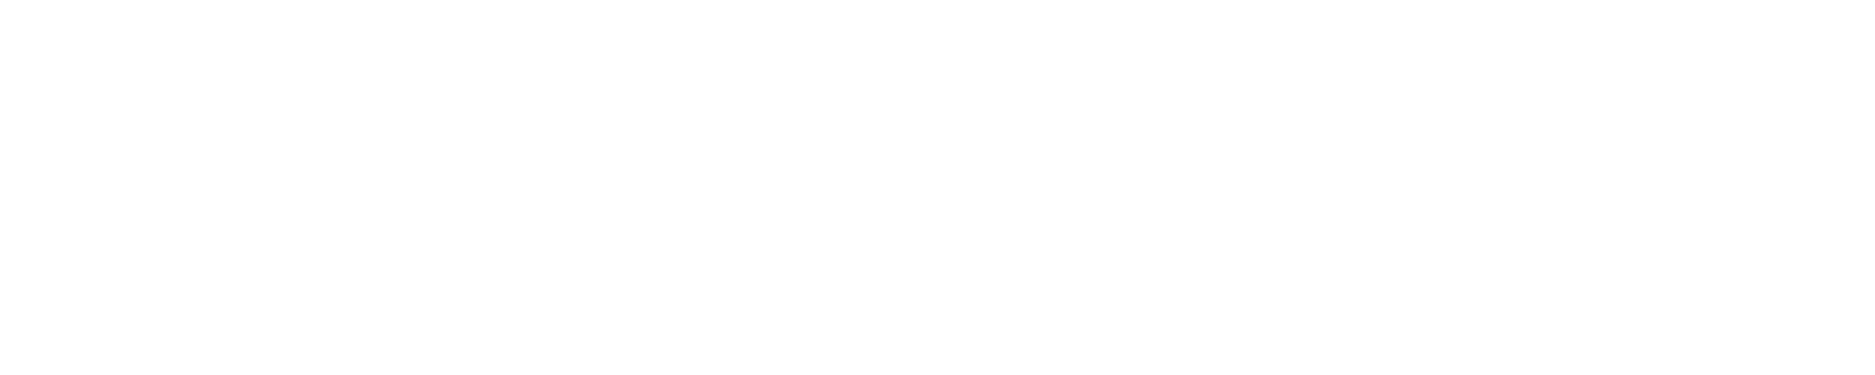

roi00306_sz30_M106


<IPython.core.display.Javascript object>


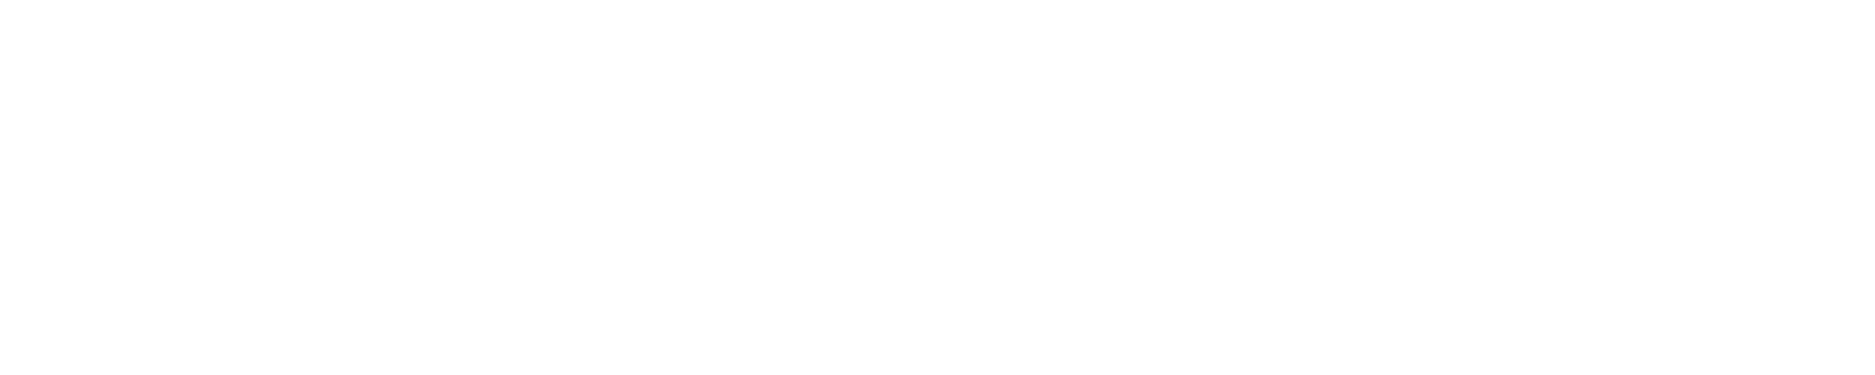

roi00310_sz30_M106
('...overblown on right edge', (1081, 1920))
('...trimming 0 off bottom', (1080, 1920))


In [161]:
rfdf = []

for curr_object in image_list:
    for size_deg in sizes:
        # Transform stimulus image
        curr_img = images[curr_object]
        imscreen = transform_stim_image(curr_img, rfparams, size_deg=size_deg, pix_per_deg=pix_per_deg)

        # Get arrays in correct orientation for multiplying
        imarray = np.flipud(imscreen).copy()
        
        for rid in roi_list:

            # Transform rfmap to screen
            rfmap = rfstats['fit_results'][rid]['data']
            rfscreen = transform_rfmap(rfmap, rfparams)
            rfarray = rfscreen.copy()
            lumarray = imarray * rfarray

            # Calculate max possible luminance
            max_brightness = np.ones(imarray.shape)*255.
            max_lum = max_brightness.ravel().dot(rfarray.ravel())

            # Express RF luminance as fraction of RF max brightness
            fraction_lum = lumarray.sum() / max_lum

            rdf = pd.DataFrame({'object': curr_object,
                                'size': size_deg,
                                'RF_luminance': fraction_lum,
                                'rid': rid}, index=[rid])
            rfdf.append(rdf)
            
            if plot_roi and size_deg in [30] and curr_object in ['M0', 'M106']:
                fig = plot_luminance_calculation(imarray, rfarray, lumarray, rfparams,
                                                 rf_cmap=rf_cmap, lum_cmap=lum_cmap)

                pl.suptitle('roi %i (%.2f)' % (int(rid+1), fraction_lum))
                label_figure(fig, data_id)

                figname = 'roi%05d_sz%i_%s' % (int(rid+1), size_deg, curr_object) 
                curr_outdir = os.path.join(outdir, 'roi-luminance-arrays', datakey)
                if not os.path.exists(curr_outdir):
                    os.makedirs(curr_outdir)
                pl.savefig(os.path.join(curr_outdir, '%s.svg' % figname))
                print(figname)
                pl.close()

rfdf = pd.concat(rfdf, axis=0)


In [162]:
print(rfdf.shape)
rfdf.head()

(1125, 4)


,RF_luminance,object,rid,size
16,0.026245,M0,16,10.0
20,0.023890,M0,20,10.0
21,0.015857,M0,21,10.0
22,0.026543,M0,22,10.0
28,0.021424,M0,28,10.0


In [163]:
# if plot_roi:
#     fig = plot_luminance_calculation(imarray, rfarray, lumarray, rfparams,
#                                      rf_cmap=rf_cmap, lum_cmap=lum_cmap)

#     pl.suptitle('roi %i (%.2f)' % (int(rid+1), fraction_lum))
#     label_figure(fig, data_id)

#     figname = 'roi%05d_%s_sz%i' % (int(rid+1), curr_object, size_deg) 
#     pl.savefig(os.path.join(outdir, 'roi-luminance-arrays', '%s.svg' % figname))
#     print(figname)
    
#     pl.close()


In [164]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.cm as cm

def create_color_bar(fig, hue_colors, hue_values, hue_param='label', #cmap='cube_helix', 
                     orientation='horizontal', cbar_axes=[0.58, 0.17, 0.3, 0.02]):

    cmap = ListedColormap(hue_colors)
    bounds = np.arange(0, len(hue_values))
    norm = BoundaryNorm(bounds, cmap.N)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array(bounds)

    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(mappable, cax=cbar_ax, boundaries=np.arange(-0.5,len(hue_values),1), \
                        ticks=bounds, norm=norm, orientation='horizontal')
    cbar.ax.tick_params(axis='both', which='both',length=0)
    cbar.ax.set_xticklabels(hue_values, fontsize=6) #(['%i' % i for i in morphlevels])  # horizontal colorbar
    cbar.ax.set_xlabel(hue_param, fontsize=12)

    return cbar

In [165]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


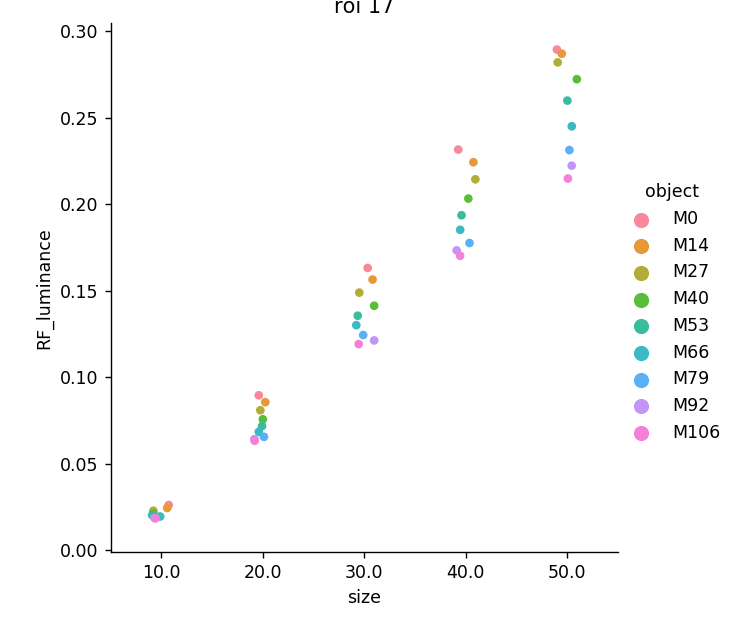

In [166]:
rid = roi_list[0]
tmpdf = rfdf[rfdf['rid']==rid]

sns.catplot(x='size', y='RF_luminance', hue='object', data=tmpdf)
pl.title('roi %i' % int(rid+1))

pl.savefig(os.path.join(outdir, 'roi-plot-RF-luminance', '%s_roi%05d.svg' % (datakey, int(rid+1))))

In [167]:
morph_cmap = 'coolwarm'
#morph_colors = sns.color_palette('cubehelix', len(image_list))
morphcolor_list = sns.color_palette(morph_cmap, len(image_list))
morph_colors = dict((morph, c) for morph, c in zip(image_list, morphcolor_list))

In [168]:
data_id

'20190606_JC091_fov1|traces001-dff_ROC-0.05'

In [169]:
morphlevels = sorted(sdf['morphlevel'].unique())
sizes = sorted(sdf['size'].unique())


In [170]:
len(roi_list)

25

In [171]:
7*4

28

<IPython.core.display.Javascript object>


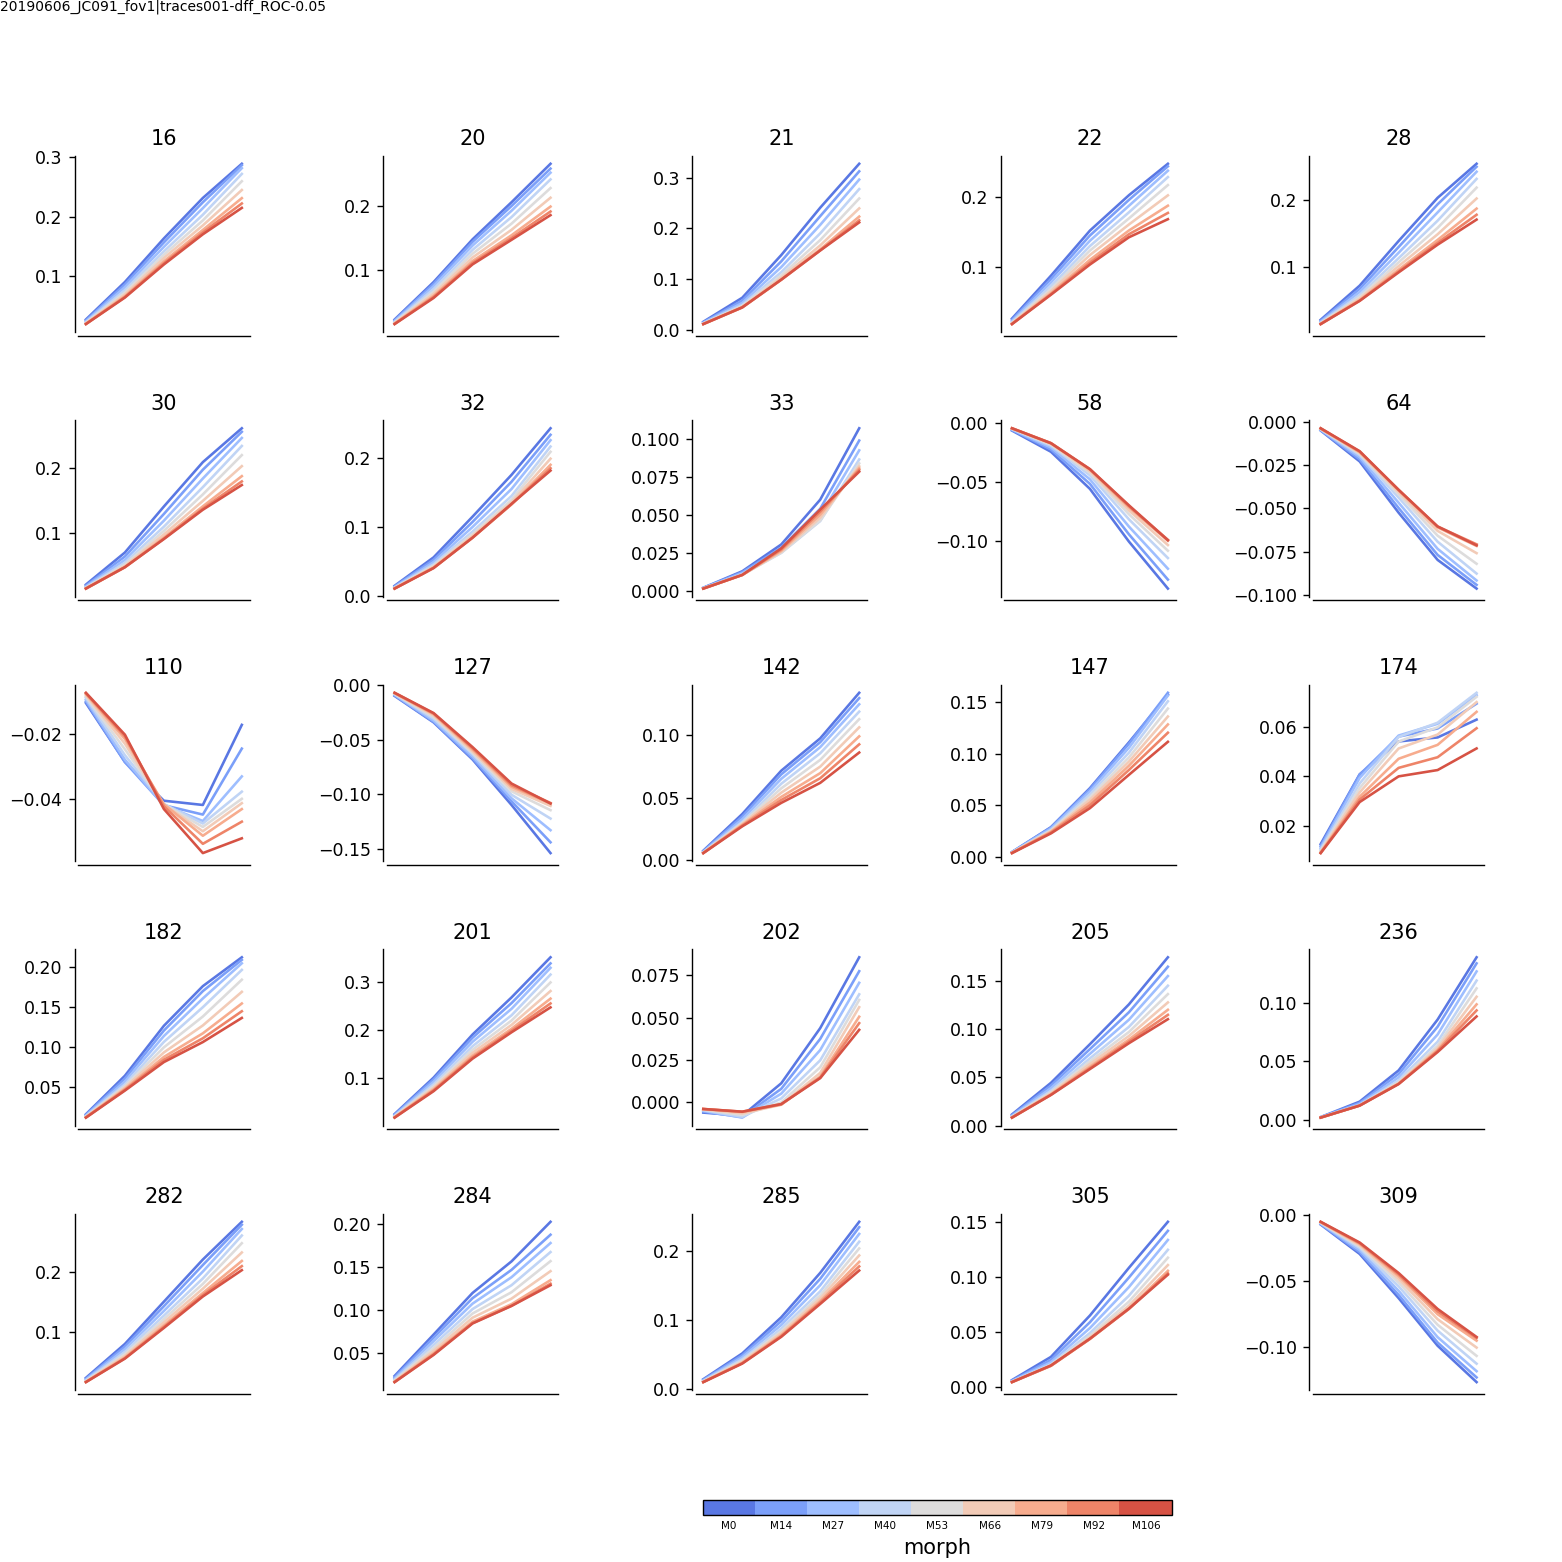

In [172]:
nc=5
nr=5
fig, axes = pl.subplots(nr, nc, sharex=False, sharey=False, figsize=(nc*2.5, nr*2.5))

ai = 0
for rid in roi_list:
    tmpdf = rfdf[rfdf['rid']==rid]
    ax = axes.flat[ai]
    for morph in image_list:
        g = tmpdf[tmpdf['object']==morph]
        ax.plot(g['size'], g['RF_luminance'], color=morph_colors[morph], label=morph)
    #ax.legend()

    if ai==(12*7)-12:
        ax.set_ylabel('RF luminance')
        ax.set_xlabel('size')
        ax.set_xticks(g['size'])
        ax.set_xticklabels([int(s) for s in g['size']])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
    sns.despine(ax=ax, trim=False, offset=2)
    ax.set_title(rid)
    ai += 1
    
pl.subplots_adjust(wspace=0.8, hspace=0.5, top=0.9, left=0.05, right=0.95)
cbar = create_color_bar(fig, morphcolor_list, image_list,
                        cbar_axes=[0.45, 0.03, 0.3, 0.01],  hue_param='morph')
label_figure(fig, data_id)
pl.savefig(os.path.join(outdir, 'roi-rf-lums_%s.svg' % datakey))

# Calculate mutual information metrics

In [135]:
def populate_bins(roi_responses, rkey='dff', n_bins=3):
    bin_labels = ['bin%i' % int(i+1) for i in np.arange(0, n_bins)]
    results, bin_edges = pd.qcut(roi_responses[rkey],
                                q=n_bins,
                                labels=bin_labels,
                                retbins=True)

#     results_table = pd.DataFrame(zip(bin_edges, bin_labels),
#                                 columns=['Threshold', 'Tier'])
    roi_responses['bin'] = results
    
    return roi_responses

In [196]:
def calculate_mutual_information(tmpd, n_bins=3):
    
    # Discretize df/f values
    tmpd = populate_bins(tmpd, n_bins=n_bins)                             
    #tmpd.groupby(['config'])['bin'].value_counts()

    # Convert responses to prob distN
    n_trials_total = float(tmpd.shape[0])
    n_reps_per_cond = float(tmpd.groupby(['config']).count().iloc[0,0])

    # Count occurrences in each state
    state_counts = tmpd.groupby(['config', 'bin']).size().reset_index(name='count')
    n_per_bin = float(state_counts.groupby(['bin'])['count'].sum().iloc[0])
    state_counts['p(s,r)'] = state_counts['count']/n_trials_total
    p_resp = n_per_bin/n_trials_total # This is uniform (since pd.qcut())
    p_stim = n_reps_per_cond/n_trials_total # This is uniform (since experimental design)

    # Calculate mutual information: 
    mi = np.array([pv*math.log(pv/(p_resp*p_stim), 2) for pv in state_counts['p(s,r)'].values]).sum()
    
    return mi


In [201]:
n_bins = 5

MI = []
for rid in roi_list:
    tmpd = pd.DataFrame(blobstats[[rid, 'config']].values, columns=['dff', 'config'], index=blobstats[rid].index)
    mi = calculate_mutual_information(tmpd, n_bins=n_bins)
    MI.append(mi)
    


<IPython.core.display.Javascript object>


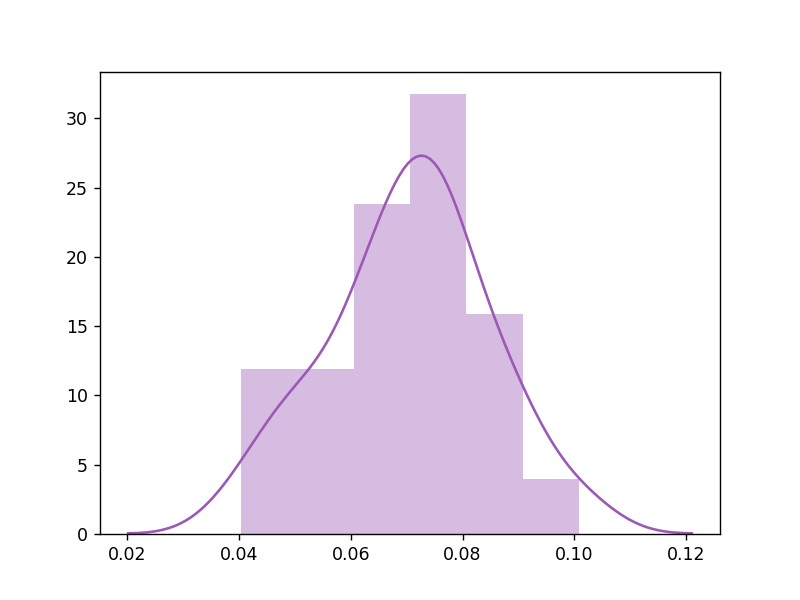

In [202]:
pl.figure()
sns.distplot(MI)

# Calculate for all cells

In [55]:
DATA.keys()[0:5]

['20190512_JC083_fov1',
 '20190420_JC076_fov1',
 '20190603_JC080_fov1',
 '20190506_JC080_fov1',
 '20190510_JC083_fov1']

In [56]:
session, animalid, fovn = datakey.split('_')
dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==int(fovn[3:]))]


,animalid,experiment,fov,session,visual_area,fovnum
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,1
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1


In [205]:
aggr_data_id = data_id.split('|')[-1]
print(aggr_data_id)
print(outdir)

traces001-dff_ROC-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis


... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 145
82 rois common to both.
... [JC080|20190506|FOV

... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 101, RFs: 152
70 rois common to both.
... [JC110|20191006|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 104, RFs: 150
65 rois common to both.
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 90, RFs: 113
69 rois common to both.
... [JC091|201906

<IPython.core.display.Javascript object>


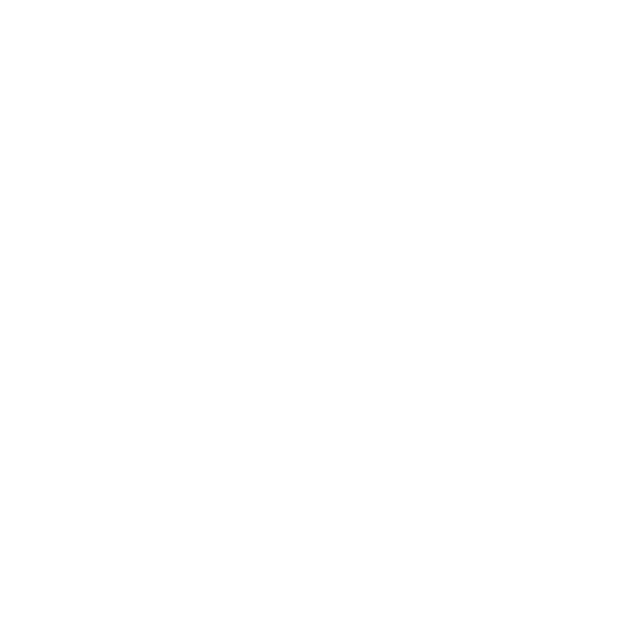

... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 145
82 rois common to both.
... [JC080|20190506|FOV

... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 101, RFs: 152
70 rois common to both.
... [JC110|20191006|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 104, RFs: 150
65 rois common to both.
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 90, RFs: 113
69 rois common to both.
... [JC091|201906

<IPython.core.display.Javascript object>


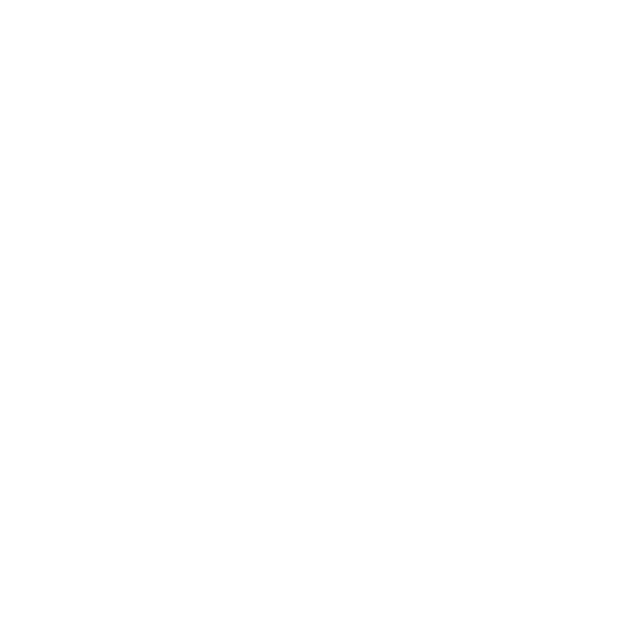

... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 145
82 rois common to both.
... [JC080|20190506|FOV

... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 101, RFs: 152
70 rois common to both.
... [JC110|20191006|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 104, RFs: 150
65 rois common to both.
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 90, RFs: 113
69 rois common to both.
... [JC091|201906

<IPython.core.display.Javascript object>


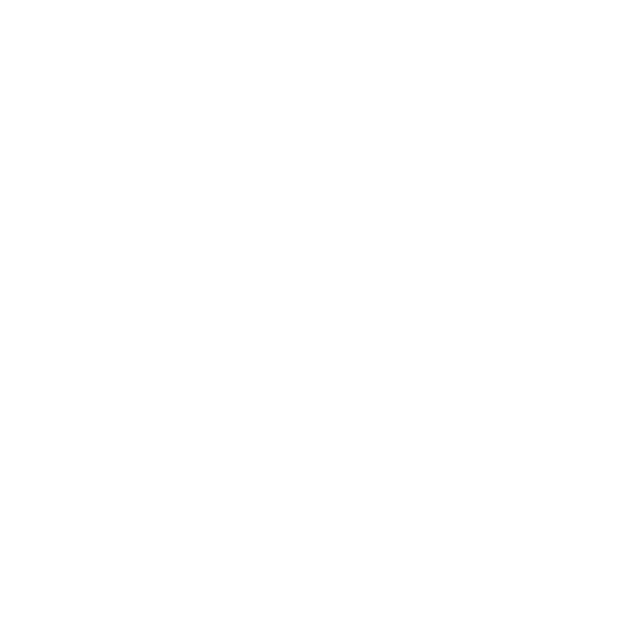

... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 145
82 rois common to both.
... [JC080|20190506|FOV

... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 101, RFs: 152
70 rois common to both.
... [JC110|20191006|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 104, RFs: 150
65 rois common to both.
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 90, RFs: 113
69 rois common to both.
... [JC091|201906

<IPython.core.display.Javascript object>


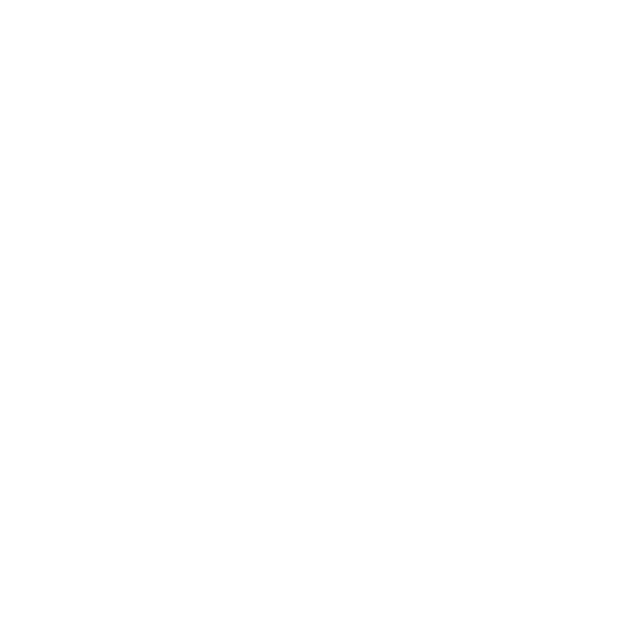

In [207]:
for n_bins in [2, 3, 4, 5]:
    mi_dfs = []
    for dii, datakey in enumerate(DATA.keys()):

        session, animalid, fovn = datakey.split('_')
        visual_area = dsets[(dsets['animalid']==animalid) \
                            & (dsets['session']==session) \
                            & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

        # Blob trial metrics
        neuraldata = DATA[datakey]['data'].copy()
        trial_key = DATA[datakey]['trial_key'].copy()
        blobstats = pd.concat([neuraldata, trial_key], axis=1)
        blobstats.index = blobstats['trial']
        blobstats.drop('trial', axis=1, inplace=True)

        # ROI list for objects
        rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
        sizes = sorted(DATA[datakey]['sdf']['size'].unique())

        # RF fit data
        g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
        curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
        exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
        rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

        # Get ROIs for both
        print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
        roi_list = np.intersect1d(rois_objects, rois_rfs)
        print("%i rois common to both." % len(roi_list))

        # Get RF/screen param info
        rfparams = get_rfparams(screen_info, rfstats)

        # Calculate MI for all cells
        MI = []
        for rid in roi_list:
            tmpd = pd.DataFrame(blobstats[[rid, 'config']].values, columns=['dff', 'config'], index=blobstats[rid].index)
            mi = calculate_mutual_information(tmpd, n_bins=n_bins)
            MI.append(mi)

        nsamples = len(MI)
        mdf = pd.DataFrame({'MI': MI,
                            'visual_area': [visual_area for _ in np.arange(0, nsamples)],
                            'datakey': [datakey for _ in np.arange(0, nsamples)],
                            'rid': roi_list})

        mi_dfs.append(mdf)

    mi_dfs = pd.concat(mi_dfs, axis=0)

    # Plot
    g = sns.catplot(x='visual_area', y='MI', kind='box', data=mi_dfs, palette='colorblind',
                order=['V1', 'Lm', 'Li'] )
    pl.ylim([0, 0.18])

    label_figure(g.fig, aggr_data_id)
    pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells.svg' % n_bins))
    
    pl.close()

<IPython.core.display.Javascript object>


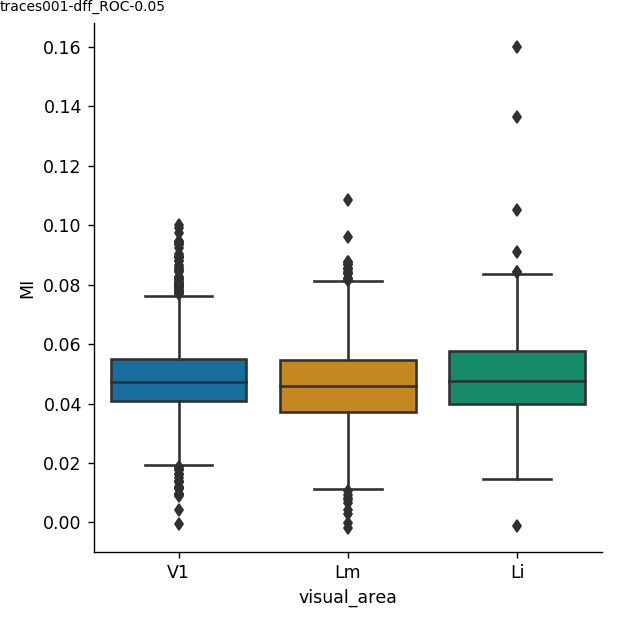

In [203]:
g = sns.catplot(x='visual_area', y='MI', kind='box', data=mi_dfs, palette='colorblind',
            order=['V1', 'Lm', 'Li'] )

label_figure(g.fig, aggr_data_id)
pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells.svg' % n_bins))

In [ ]:
g.f